# Question 2: Classification
## Machine Learning Foundations with Python 
### 90-803 - Spring 2024
### Sprint Team #17
### Name:  Jewel Yoko Kentilitisca, Hannah Ngyugen, Quintessa Guegerich
___


### Question 2 Classification Outline

1: Data Pre-Processing 
   a. Preprocessing data
   b. Data Exploration
   c. Merging with Ransac Data with our merged_data frame

2: Making this into a classification problem
   a. Divide our data into specific regions that have similar temperatures
   b. Looking at distributions based on regions

3: Running the models: for Warm States
   1. Naive Bayes
   2. Logistic Regression
   3. KNN
   4. Random Forests Classifier
   5. Decision Tree Classifier
   6. Adaboost 
   7. New Model - XGBoost

4: Running the models: for Cold States
   1. New Model - XGBoost

5: Running the models: for All States
   1. New Model - XGBoost

6: Evaluation and Interpretation
   1. Recall Scores for Warm States
   2. Feature Importance for Warm, Cold, and All States

___


### Can we classify counties in historically "Warm Temperature", "Moderate Temperature", and "Cold Temperature" States as Not Outliers and Outliers ?
   -Based on our linear regression  (using RANSAC) we were able to classify counties as outliers and not outliers. In this case we want to apply that to regions who are within the same annual temperature average. 
   Target variable: The target variable for this classification problem is to classify outlier and not outlier counties. 
    (a) 1 - Outliers
    (b) 0 - Not outliers
    
We are curious to see if low temperatures anomalies lead to a decrease/no change in property prices or vice versa.


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Importing preprocessing and modeling libraries
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Import state abbreviations and FIPS
from state_names import state_abbreviations, state_to_fips

### *1a. Preprocessing the Data*

In [11]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv', index_col=0)
merged_data.head()
merged_data['StateFPS'] = merged_data['StateAbbrv'].map(state_to_fips)
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = us_counties.merge(merged_data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])
merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

#Changing variable name
filtered_states = merged_data
filtered_states.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)



___
### *1b. Data Exploration*

In [12]:
filtered_states_sorted = filtered_states.sort_values(by='Anomaly (1901-2000 base period)', ascending=False)

filtered_states_sorted.describe()

,ALAND,AWATER,INTPTLAT,INTPTLON,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
count,5.798940e+05,5.798940e+05,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,5.798940e+05,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000
mean,2.338742e+09,1.819740e+08,37.986718,-89.613755,2010.712761,6.434317,94103.848741,2.851340e+05,55.702485,1.385632,54.317547,0.891515,4.955709,22.500000,177.251586,260.126543,72.512364,37.364843
std,3.703393e+09,5.523955e+08,4.615860,12.635366,5.361191,3.466285,64177.827177,2.108634e+05,17.135498,3.388082,17.099949,0.365064,1.232351,7.500006,36.994047,36.813915,8.549974,29.181675
min,5.868388e+07,9.251200e+04,25.586120,-124.210929,2000.000000,1.000000,6109.396309,5.947229e+04,-5.200000,-22.200000,1.800000,0.180000,2.890000,15.000000,60.300000,124.000000,42.300000,1.300000
25%,1.055922e+09,1.047176e+07,34.763109,-94.888456,2007.000000,3.000000,52879.469613,1.884248e+05,42.800000,-0.700000,41.300000,0.540000,3.980000,15.000000,150.900000,237.700000,67.100000,7.700000
50%,1.479110e+09,2.694270e+07,38.423084,-86.034263,2011.000000,6.000000,77205.031646,2.347503e+05,57.200000,1.300000,55.500000,0.910000,4.650000,22.500000,179.800000,262.500000,74.800000,32.450000
75%,2.206699e+09,8.116171e+07,41.355319,-81.400955,2015.000000,9.000000,115764.095664,3.139183e+05,70.000000,3.400000,68.800000,1.220000,5.960000,30.000000,204.400000,286.100000,80.300000,65.500000
max,5.197631e+10,1.405367e+10,48.842653,-68.666616,2019.000000,12.000000,915009.312632,5.178158e+06,96.200000,19.800000,91.700000,1.510000,8.550000,30.000000,254.800000,347.300000,83.500000,82.900000


In [13]:
filtered_states['Average Temperature Value'].describe()

count    579894.000000
mean         55.702485
std          17.135498
min          -5.200000
25%          42.800000
50%          57.200000
75%          70.000000
max          96.200000
Name: Average Temperature Value, dtype: float64

In [14]:
filtered_states['Anomaly (1901-2000 base period)'].describe()

count    579894.000000
mean          1.385632
std           3.388082
min         -22.200000
25%          -0.700000
50%           1.300000
75%           3.400000
max          19.800000
Name: Anomaly (1901-2000 base period), dtype: float64

We see that there are significant regional temperature differences within these particular states, meaning that it might be useful dividing states up regionally based on similarities in average temperatures. 

Comparing an area’s recent temperature to its long-term average can tell how warm or how cool the area is compared to usual. Temperature anomalies also give us a frame of reference to better compare location. So for our data we will also be labeling areas based on regional similarities. 

So it looks like after scaling our data, we would want to divide our data into 3 regions. By doing so we are able to find outliers for states that are grouped together based on similarities in average temperatures. 

Another option is to classify based on domain knowledge. 
Since we know whih specific regions have the same annual temperature in terms of climate similarities we can divide things up regionally.
I divided based on average annual temperature ranks from the NOAA data. 

---
### *1c. Merging with Linear Regression Outlier Data*


In [15]:
#merging with outlier data 
outliers = pd.read_csv('all_data_w_outliers.csv',low_memory=False)

data = pd.merge(filtered_states, outliers[['Is_Outlier']], left_index=True, right_index=True)

In [16]:
# # Define temperature categories
# def categorize_temperature(temperature):
#     if temperature > 65:
#         return 'Warm'
#     elif temperature > 55:
#         return 'Moderate'
#     elif temperature > 45:
#         return 'Cold'

temperature_regions = {
    'Warm all year round': ['HI', 'FL', 'LA', 'AZ', 'TX', 'MS', 'AL', 'GA', 'SC', 'CA'],
    'Moderate': ['OK', 'AR', 'NC', 'TN', 'NV', 'KY', 'VA', 'MO', 'KS', 'MD', 'DE', 'WV', 'NM', 'NJ', 'IN', 'IL', 'OR', 
                 'OH', 'WA', 'NE', 'PA', 'UT', 'RI', 'CT', 'NY', 'MA', 'IA', 'MI', 'CO'],
    'Cold': ['ID', 'SD', 'WI', 'NH', 'MT', 'VT', 'WY', 'ME', 'MN', 'ND', 'AK']
}

# Add a new column 'Temperature_Category' to data based on state abbreviations
data['Temperature_Category'] = data['StateAbbrv'].map({state: category for category, states in temperature_regions.items() for state in states})

# Initialize 
label_encoder = LabelEncoder()

# Fit and transform the 'Temperature_Category' column
data['Temperature_Category_Label'] = label_encoder.fit_transform(data['Temperature_Category'])

data.drop(columns=['Temperature_Category', 'Date'], inplace=True)

# DataFrame
data.head()

#0 = Cold, 1=Moderate, 2= Warm

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS,Is_Outlier,Temperature_Category_Label
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,0.93,8.01,15,103.0,173.6,64.7,7.0,31,True,1
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,0.81,8.20,30,129.9,166.8,81.1,61.1,31,True,1
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,0.91,8.18,15,100.5,172.8,63.1,7.2,31,True,1
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,0.78,8.39,30,127.8,163.7,81.2,58.6,31,True,1
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,0.87,8.24,15,101.2,176.9,62.7,7.2,31,True,1


___
### 2. *Figuring out how to make this into a classification problem*

1. Make temperature into a multiclass of 1 = Low, 2 = Medium, and 3 - High in terms of temperature risk based on anomalies (did not go with this option)
2. Look at the ratio changes between purchase price, bottom tier average home value estimate, and top tier average home value estimate, grouping by month/year. (did not go with this option)
3. Include temperature anomaly data into one combined value reflecting the impact on housing prices, trying to calculate by putting weights? (did not go with this option)

    -Normalizing the Temperature Anomaly Data: Ensure that the temperature anomaly data is on a similar scale as the housing price data. This might involve scaling or normalization. (ended up using MinMax Scaler and PowerTransformer)

    -Define Weights: Assign weights to the housing price change and temperature anomaly change based on their relative importance in influencing housing prices. These weights can be subjective. (did not follow this idea)

    -Calculate Combined Impact: Multiply the percentage change in housing prices and the normalized temperature anomaly data by their respective weights, and then add them together to get a combined impact value. (could not find a concise way to do this idea)

    -Outlier Classification: Using RANSAC data to classify outliers and try looking at regions vs. looking at all the states together (went with this idea)

### Intention: Look if positive values may indicate that higher temperature anomalies are associated with a higher likelihood of a certain class (higher percentage change in housing prices, both for bottom tier and top tier), while negative values may indicate the opposite.

#### Dropping unnecessary columns 

In [17]:
#Keep Is_Outlier 
#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Is_Outlier']
data[columns_to_float] = data[columns_to_float].astype(float)

# Get column names with object data types
object_columns = data.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
data = data.drop(object_columns, axis=1)
data = data.drop(columns='geometry', axis=1)


In [18]:
#Checking if there's nulls
# your code here
pd.concat({"Number missing values":data.isnull().sum()
            , "Percentage of missing values":data.isnull().sum()*100/data.shape[0]}
            , axis=1)

nan_rows = data[data['Is_Outlier'].isna()]
nan_rows.sample(20)

data.dropna(subset=['Is_Outlier'], inplace=True)


### *2a. Divide our data into specific regions that have similar temperatures, based on average annual temperatures from NOAA data 2001 since this is where our data is starting from.*

In [19]:
# Filter the DataFrame for warm states
warm_states = data[data['Temperature_Category_Label'] == 2]

# Filter the DataFrame for moderate states
moderate_states = data[data['Temperature_Category_Label'] == 1]

# Filter the DataFrame for cold states
cold_states = data[data['Temperature_Category_Label'] == 0]

### *2b. Looking at distributions of Temperature and Housing Prices*

In [20]:
warm_states['Anomaly (1901-2000 base period)'].describe()

count    136736.000000
mean          1.286621
std           2.881352
min         -10.100000
25%          -0.500000
50%           1.200000
75%           3.000000
max          14.000000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Warm States')

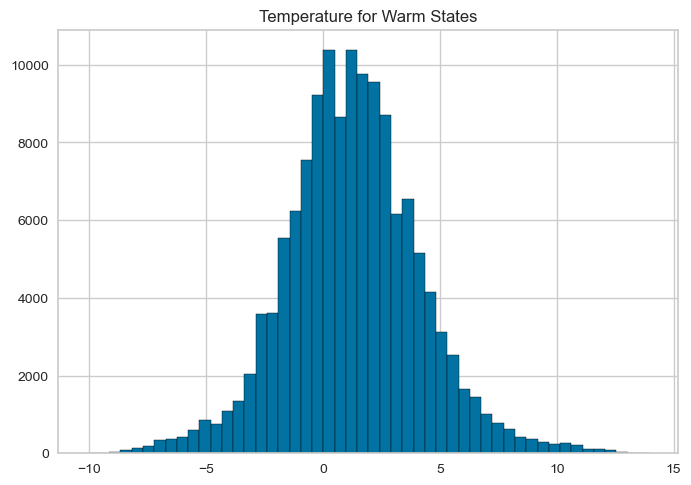

In [21]:
plt.hist(warm_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Warm States')

Warm states follow a relatively normal standard distribution. 

Text(0.5, 1.0, 'Purchase Price for Warm States')

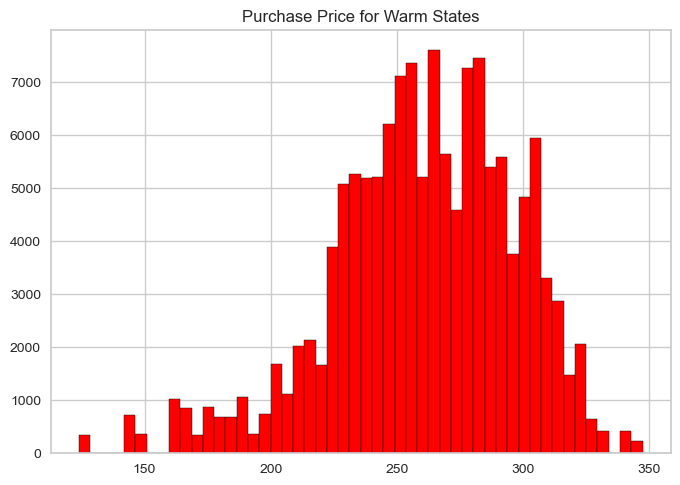

In [22]:
plt.hist(warm_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Red') 
plt.title('Purchase Price for Warm States')

In [23]:
warm_states['Purchase Price ($thou)'].describe()


count    136736.000000
mean        260.511977
std          36.799174
min         124.000000
25%         238.100000
50%         262.800000
75%         286.300000
max         347.300000
Name: Purchase Price ($thou), dtype: float64

In [24]:
moderate_states['Anomaly (1901-2000 base period)'].describe()

count    320362.000000
mean          1.384600
std           3.482949
min         -14.900000
25%          -0.800000
50%           1.300000
75%           3.500000
max          17.900000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Moderate States')

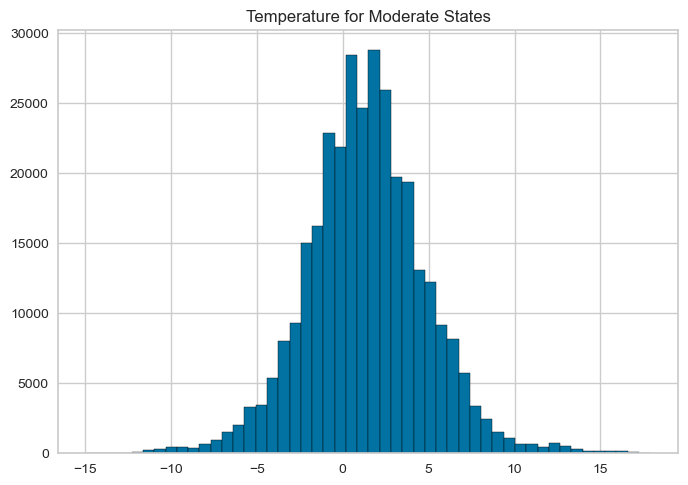

In [25]:
plt.hist(moderate_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Moderate States')

Moderate states also follow a relatively standard normal distribution. 

Text(0.5, 1.0, 'Purchase Price Moderate States')

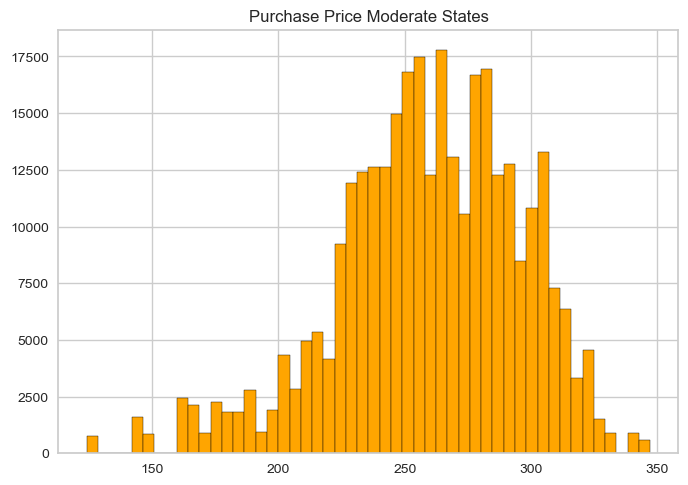

In [26]:
plt.hist(moderate_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Orange') 
plt.title('Purchase Price Moderate States')

In [27]:
moderate_states['Purchase Price ($thou)'].describe()

count    320362.000000
mean        259.348872
std          36.944437
min         124.000000
25%         236.700000
50%         262.000000
75%         285.600000
max         347.300000
Name: Purchase Price ($thou), dtype: float64

In [28]:
cold_states['Anomaly (1901-2000 base period)'].describe()

count    47254.000000
mean         1.672531
std          4.087012
min        -22.200000
25%         -0.600000
50%          1.500000
75%          3.900000
max         19.800000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Cold States')

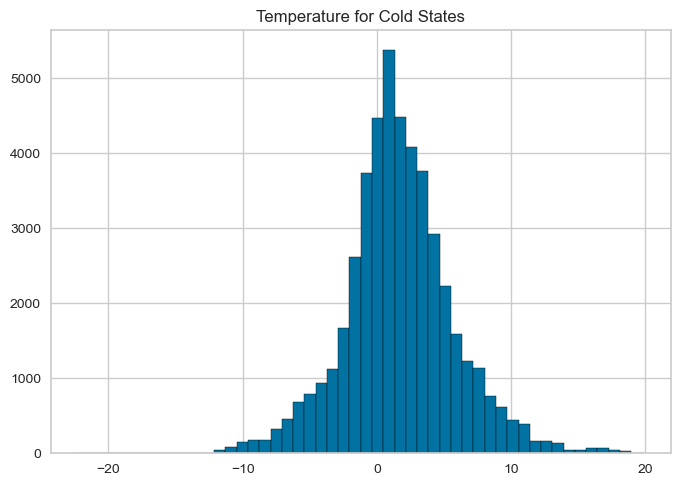

In [29]:
plt.hist(cold_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Cold States')

Colder states also follow a normal distribution with some outliers with lower values in the negatives. 

Text(0.5, 1.0, 'Purchase Price Cold States')

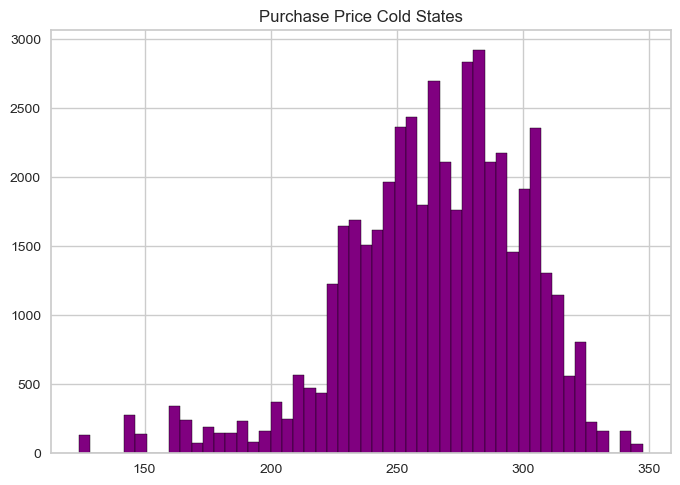

In [30]:
plt.hist(cold_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Purple') 
plt.title('Purchase Price Cold States')

In [31]:
cold_states['Purchase Price ($thou)'].describe()

count    47254.000000
mean       264.790979
std         35.692109
min        124.000000
25%        244.500000
50%        267.900000
75%        289.900000
max        347.300000
Name: Purchase Price ($thou), dtype: float64

In [32]:
warm_states.sort_values(by='Purchase Price ($thou)', ascending=False)

,ALAND,AWATER,INTPTLAT,INTPTLON,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),Is_Outlier,Temperature_Category_Label
326698,1.197061e+10,47476264.0,32.931828,-109.878310,2008,1,109294.837231,283746.130713,42.1,-0.5,42.6,0.41,5.65,15,141.3,347.3,49.5,6.5,0.0,2
266522,2.034280e+09,62287592.0,33.266893,-86.661007,2008,1,137273.201673,359656.499536,42.0,-1.7,43.7,0.41,5.65,15,141.3,347.3,49.5,6.5,0.0,2
329352,1.337632e+09,222884791.0,31.807458,-81.457871,2008,1,97454.911012,241076.841890,49.8,-0.7,50.5,0.41,5.65,15,141.3,347.3,49.5,6.5,1.0,2
414164,7.665674e+08,13263789.0,33.291347,-85.137886,2008,1,35801.149440,210688.070215,40.9,-1.7,42.6,0.41,5.65,15,141.3,347.3,49.5,6.5,0.0,2
266100,1.636888e+09,31084093.0,39.270130,-121.344259,2008,1,97411.527819,284068.352995,42.6,-1.9,44.5,0.41,5.65,15,141.3,347.3,49.5,6.5,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122414,1.297342e+09,10832501.0,33.029267,-84.667058,2011,11,25012.748328,134220.685387,54.4,2.1,52.3,0.63,4.32,15,88.2,124.0,73.9,4.7,1.0,2
367882,1.364328e+09,19520065.0,33.790034,-84.468182,2011,11,56951.411008,391788.617057,53.5,2.9,50.6,0.63,4.32,15,88.2,124.0,73.9,4.7,1.0,2
264196,1.902966e+09,52529994.0,34.131923,-86.869267,2011,11,72916.785462,234847.310396,52.5,2.1,50.4,0.63,4.32,15,88.2,124.0,73.9,4.7,0.0,2
220440,8.254327e+08,20273034.0,33.452947,-84.154021,2011,11,63395.503376,183937.457935,54.0,2.0,52.0,0.63,4.32,15,88.2,124.0,73.9,4.7,1.0,2


---

## *3. Classification Models and Hyperparameter Tuning for Outliers* 
Based on additional comments from Miguel, we will run model for Warm States, Cold States, and All States. Based on the models that perform the best for warm states, we will apply that model to Cold States and All States to see the differences in classification. Noted that we will try PowerTransformer and MinMaxScaler to standardize our data and see if they perform different or the same. 

 1. Naive Bayes
 2. Random Forests Classifier
 3. Logistic Regression
 4. Adaboost 
 5. New Model - XGBoost




## Train/Test Splitting Data for *Warm States*

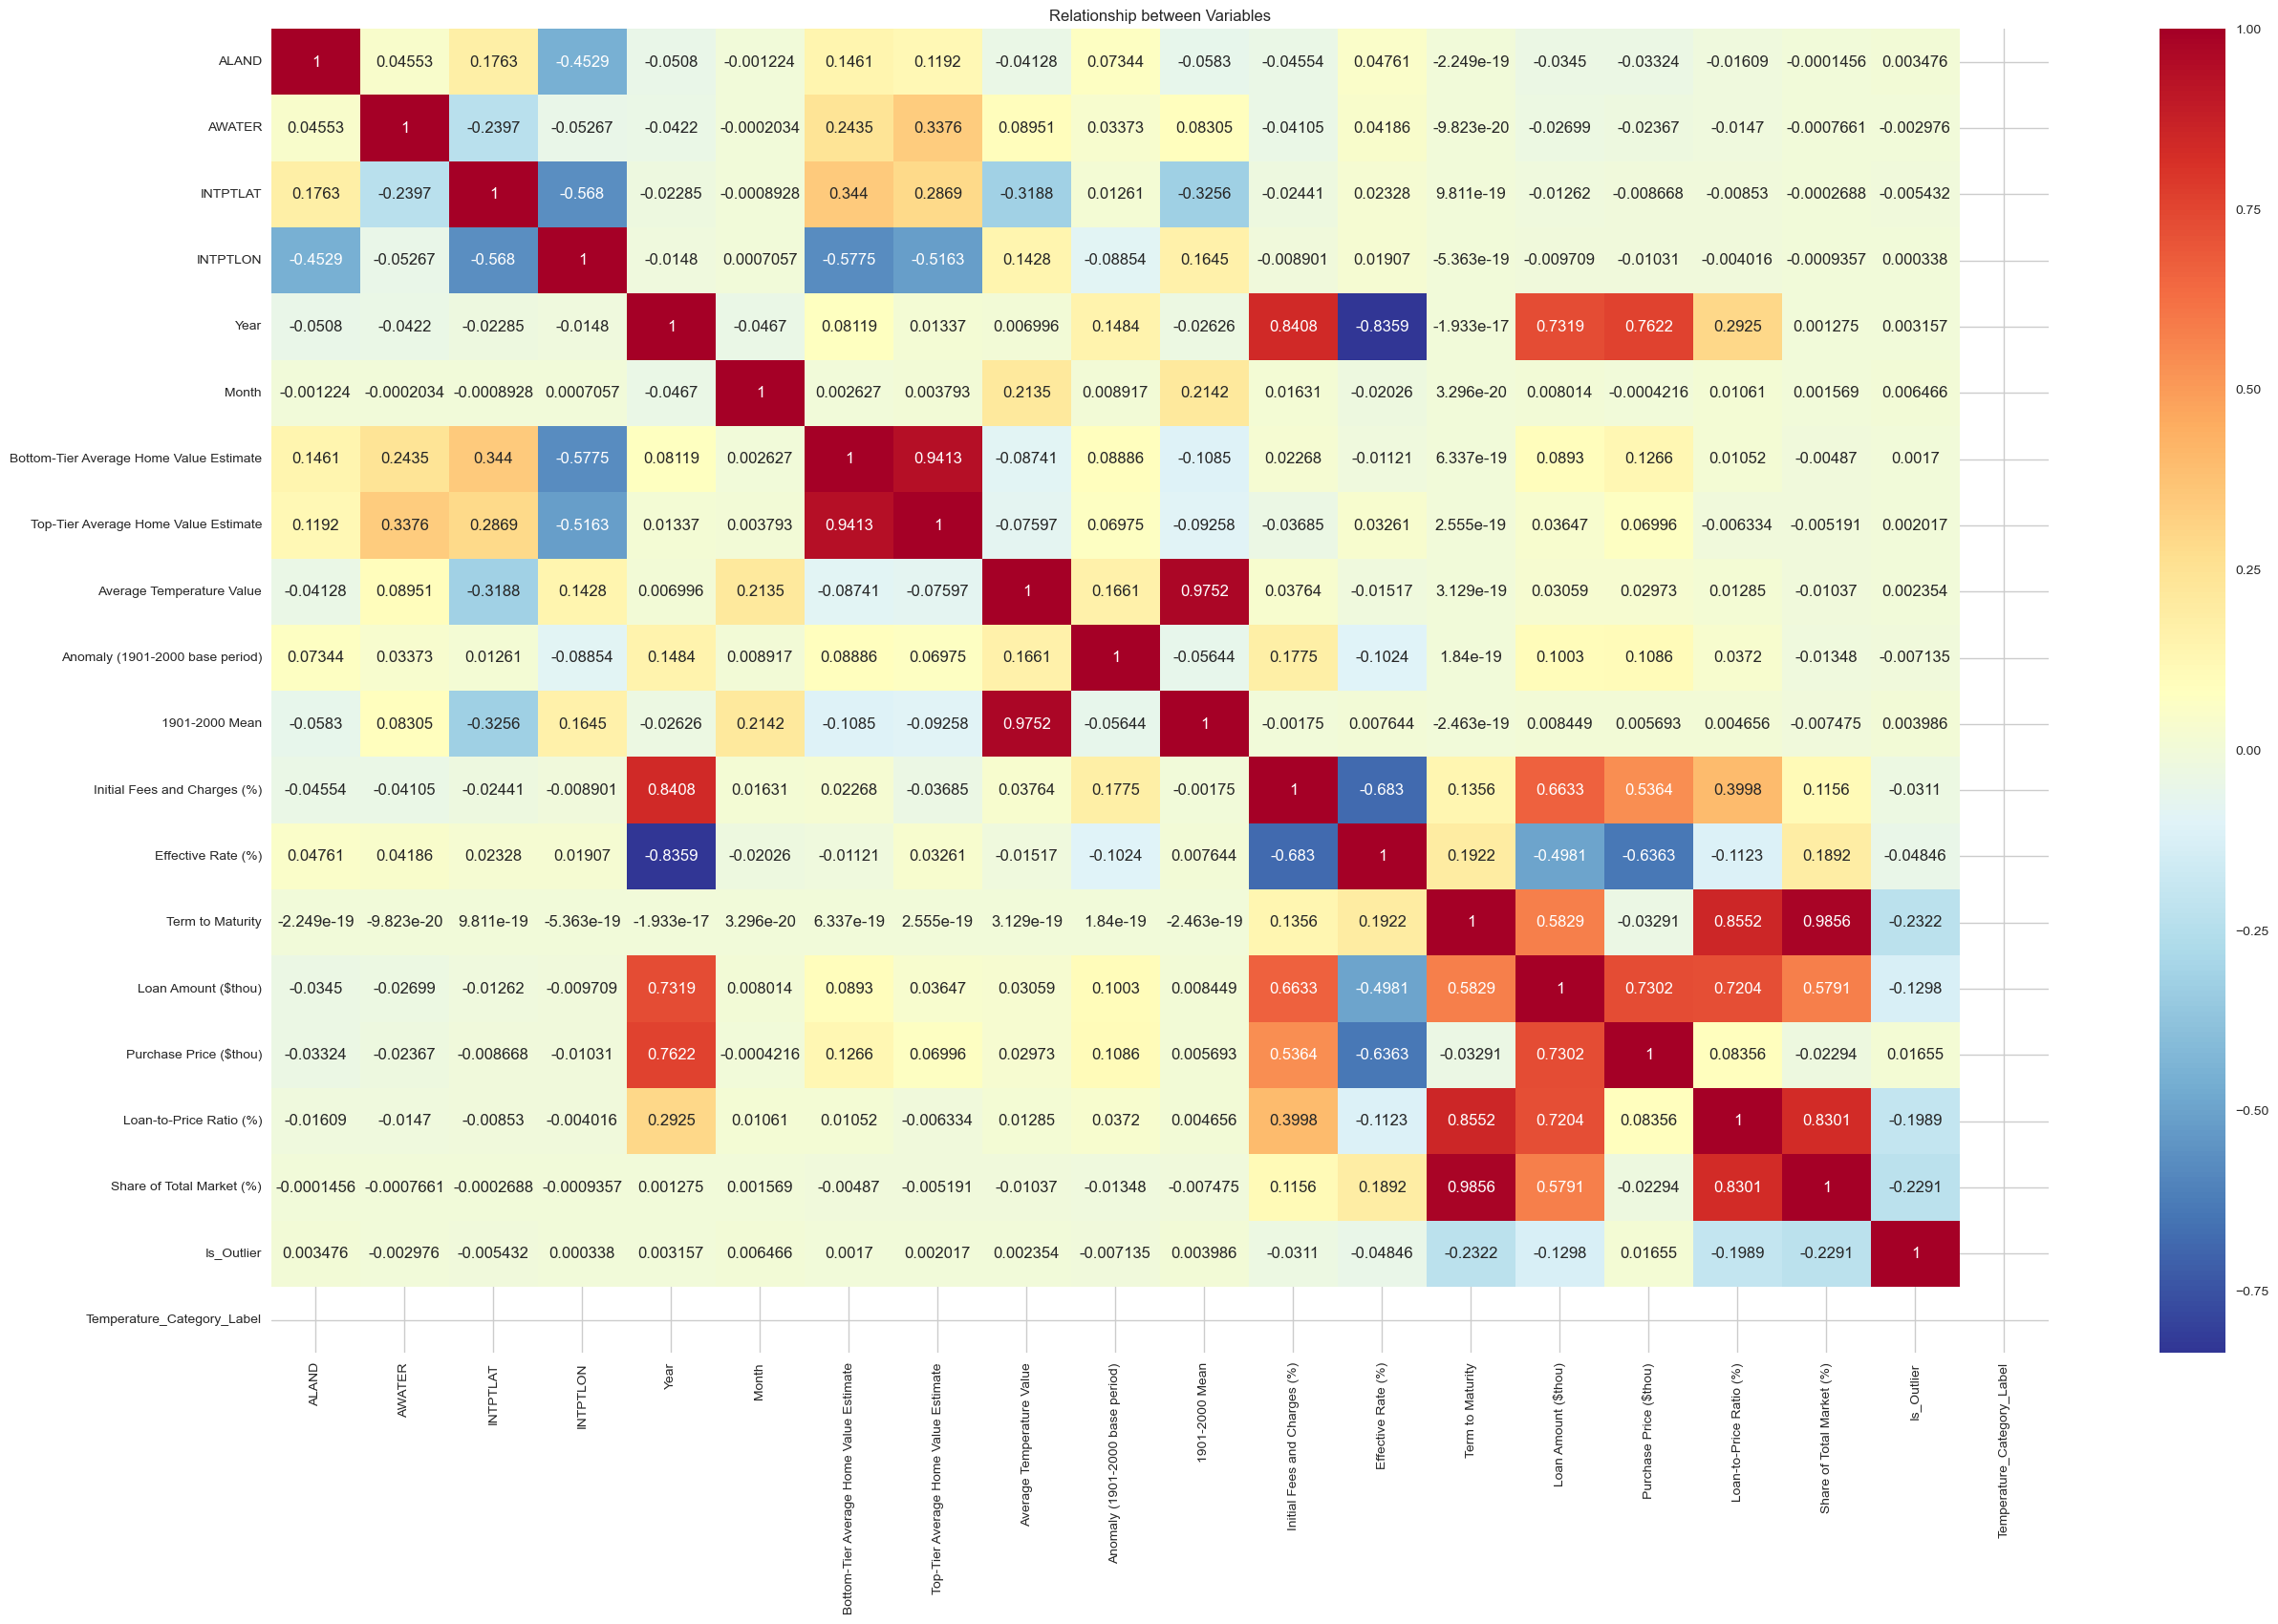

In [33]:
corr_matrix = warm_states.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [34]:
#Need to drop highly correlated variables 
warm_states = warm_states.drop(columns=['Term to Maturity', 'Loan-to-Price Ratio (%)', '1901-2000 Mean'])

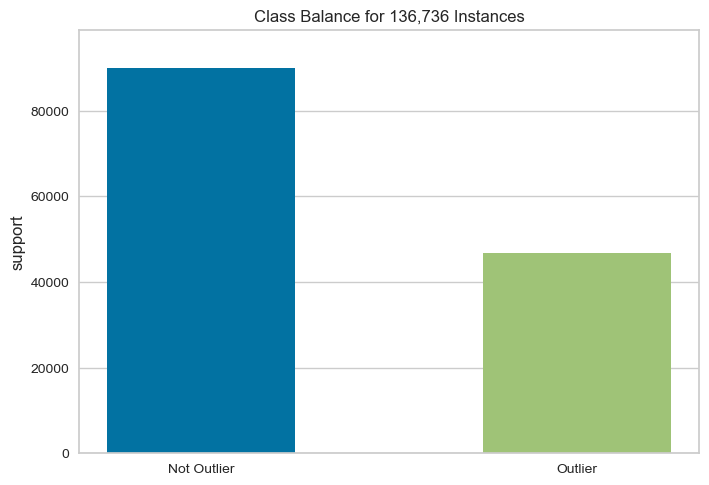

<Axes: title={'center': 'Class Balance for 136,736 Instances'}, ylabel='support'>

In [35]:
# Getting features for test and train 
labels = ["Not Outlier", "Outlier"]

visualizer = ClassBalance(labels=labels)
visualizer.fit(warm_states['Is_Outlier'])

# Show the visualizer
visualizer.show()

We wanted to use a train test split using all the data because by using all historical data for training, we wanted to maximize the amount of information that our model could learn from. 

In [36]:
from sklearn.preprocessing import MinMaxScaler

seed=11

#standardizing the data 
X = warm_states[warm_states.columns.difference(['Is_Outlier'])]
y = warm_states['Is_Outlier']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler to the specified columns of the training data
scaler.fit(X_train[columns_to_scale])

# Transforming the train and test data based on the fitted scaler
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

print(y_test)


315688    0.0
52051     0.0
395664    1.0
498403    0.0
274210    0.0
         ... 
282383    0.0
13082     0.0
498258    0.0
475131    0.0
56373     0.0
Name: Is_Outlier, Length: 34184, dtype: float64


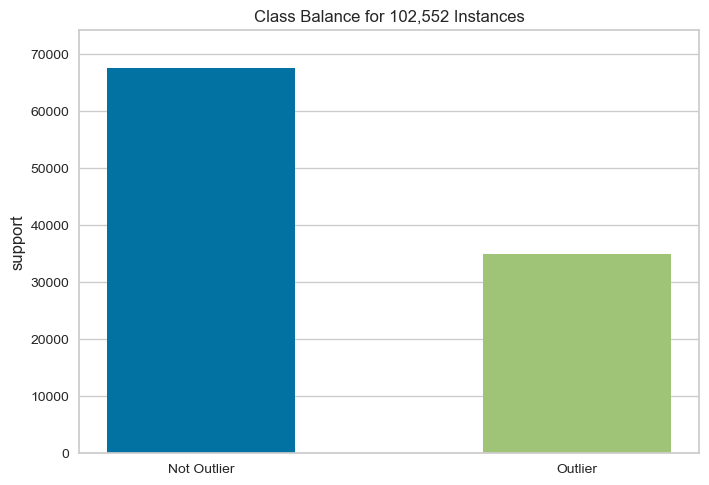

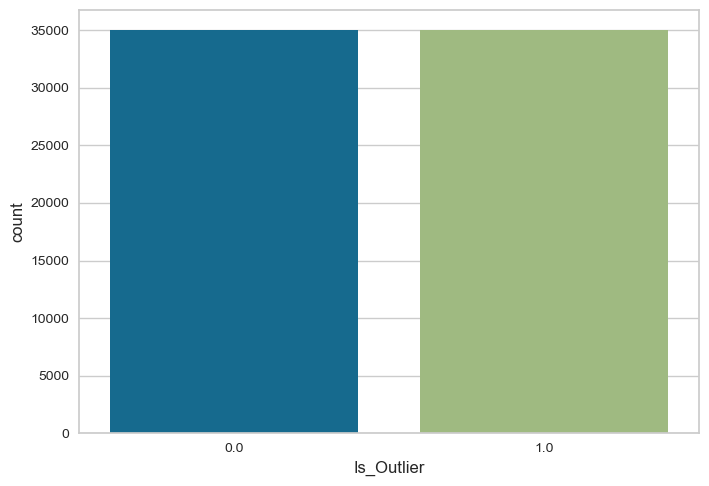

In [37]:
#We want to undersample
# your code here

visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

# Visualize class balance after undersampling
sns.countplot(x=y_train_resampled, tick_label=labels)
plt.show()

Before starting, I think it is more harmful to miss labeling an outlier. Given this scenario, since we are trying to look for areas affected by temperature anomalies on housing prices, it would be more harmful in missing labeling an outlier than incorrectly labeling a not outlier as an outlier. Since recall measures the ability of a model to correctly identify all relevant instances (outliers in this case), we would want to reduce the number of false negatives. We would be able to minimize the risk of failing to identify areas affected by temperature anomalies on housing prices.



### 1. Naive Bayes

[[20625  1719]
 [10924   916]]
              precision    recall  f1-score   support

 Not Outlier       0.65      0.92      0.77     22344
     Outlier       0.35      0.08      0.13     11840

    accuracy                           0.63     34184
   macro avg       0.50      0.50      0.45     34184
weighted avg       0.55      0.63      0.54     34184



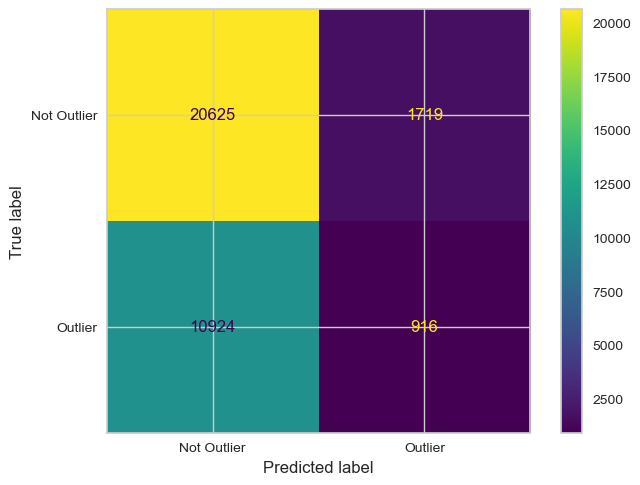

In [68]:
# your code here
modelNB = GaussianNB()

#Training the model
modelNB.fit(X_train_resampled, y_train_resampled)

#Getting predictions
y_train_pred_NB = modelNB.predict(X_train_resampled)
y_test_pred_NB = modelNB.predict(X_test_scaled)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_NB))

#Labels
labels = ["Not Outlier", "Outlier"]

#Print the classification report
print(classification_report(y_test, y_test_pred_NB, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


Naive Bayes performs really bad in looking for outliers, so we don't want to go down this path for finetuning. It does perform well in identifying not outliers. 

### 2. Random Forests Classifier

[[14336  7769]
 [ 3756  7652]]
              precision    recall  f1-score   support

 Not Outlier       0.79      0.65      0.71     22105
     Outlier       0.50      0.67      0.57     11408

    accuracy                           0.66     33513
   macro avg       0.64      0.66      0.64     33513
weighted avg       0.69      0.66      0.66     33513



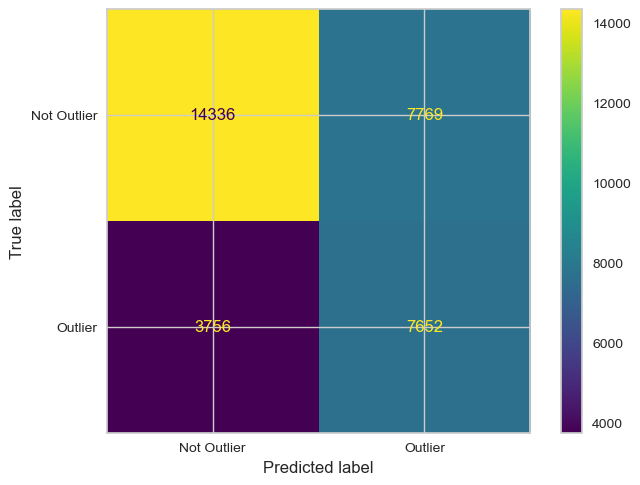

In [ ]:
# your code here
model_rf = RandomForestClassifier()

#Fit the model
model_rf.fit(X_train_resampled, y_train_resampled)

#Evaluating the performance
y_pred_train_rf = model_rf.predict(X_train_resampled)
y_pred_test_rf = model_rf.predict(X_test_scaled)

#Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_rf))

#Classification Report
print(classification_report(y_test, y_pred_test_rf, target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

RFC performs moderately well with a recall score of 0.65 for not outliers and 0.67 for outliers. We will continue and finetune this model to try getting better results. It suggests that our model is relatively okay at identifying both regular data points and anomalies. 

___
#### Parameters we want to finetune: 

For Random Forests Classifier: 
n_estimators: This gives us the number of trees in the forest. Increasing the number of trees could possibly improve the model's ability to capture the complex relationships in the data, and in this case is outliers, so we will be trying different ranges of n_estimators. 
max_depth: Gives the max depth of each tree so that a deeper tree structure allows the model to capture more intricate patterns in the data. This could aid in distinguishing the outliers from normal data points.
min_samples_split: These parameters control the minimum number of samples required to split an internal node. So we would want to set higher values for these parameters to help prevent the model from overfitting to noise in the data and so preserving the meaning of the outliers.
max_features: Looks at the number of features to consider when looking for the best split. Putting bounds on the number of features considered at each split can help prevent the model from focusing too much on features that are irrelevant and  could improve its ability to identify meaningful outliers.



In [ ]:
# your code here

# Parameters
parameters = {'n_estimators': [50, 100, 200],'max_depth': [10, 15, 20, 30], 'max_features': ("sqrt", "log2")}

# Initialize
model_rfc_grid_search = GridSearchCV(model_rf, param_grid=parameters, cv=5, scoring='recall_micro')

# Train
model_rfc_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_rfc_grid_search.best_params_)

{'max_depth': 20, 'n_estimators': 200}


[[17280  5064]
 [ 7464  4376]]
              precision    recall  f1-score   support

 Not Outlier       0.70      0.77      0.73     22344
     Outlier       0.46      0.37      0.41     11840

    accuracy                           0.63     34184
   macro avg       0.58      0.57      0.57     34184
weighted avg       0.62      0.63      0.62     34184



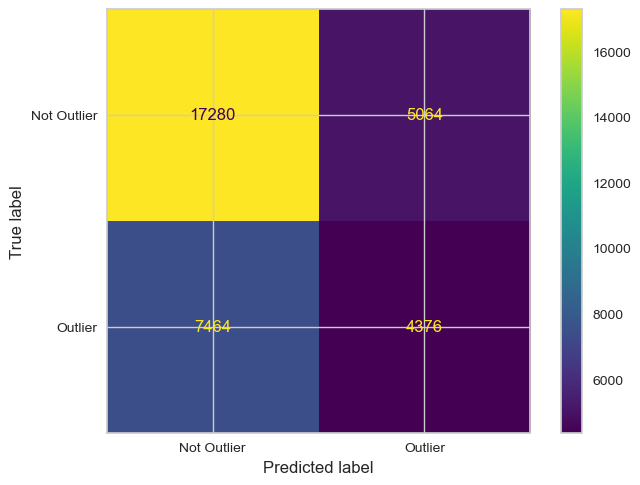

In [44]:
# your code here
rfc_best = RandomForestClassifier(max_depth=30, max_features= 'log2', n_estimators=200)

#Fit the model
rfc_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_rfc_best = rfc_best.predict(X_train_resampled)
y_pred_test_rfc_best = rfc_best.predict(X_test)

#Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_rfc_best))

#Classification Report
print(classification_report(y_test, y_pred_test_rfc_best, target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_rfc_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


### 3. Logistic Regression

In [38]:
# your code here
model_lr = LogisticRegression(max_iter=10000)

#Fitting the model to MinMaxScaled data 
model_lr.fit(X_train_resampled, y_train_resampled)

#Getting predictions
y_train_pred_lr = model_lr.predict(X_train_resampled)
y_test_pred_lr = model_lr.predict(X_test_scaled)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_lr))

#Print the classification report
print(classification_report(y_test, y_test_pred_lr, target_names=labels, zero_division=1))

[[  885 21459]
 [  413 11427]]
              precision    recall  f1-score   support

 Not Outlier       0.68      0.04      0.07     22344
     Outlier       0.35      0.97      0.51     11840

    accuracy                           0.36     34184
   macro avg       0.51      0.50      0.29     34184
weighted avg       0.57      0.36      0.23     34184



The C parameter is the regularization parameter. So, in this model, we want lower values of C increase the regularization strength, which can help prevent overfitting. Since we are dealing with outlier detection, we want to prevent overfitting so the model can generalize well to unseen outliers. We also want to experiment with class weights since we want to classify outliers well, so the class_weight parameter assigns higher weights to the minority class which is the outliers, we want the model to pay more attention to identifying these events, so can see how the model performs with varying degrees of emphasis on outliers. Decided to use saga for the solver parameter since liblinear works well with smaller datasets, and our dataset is large and saga can handle L1 regularization effectively. 

In [41]:
#Parameters we want to look at 
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'solver': ['saga'],  
    'penalty': ['l1', 'l2'],  
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]  
}

# Initialize a GridSearchCV object
model_lr = LogisticRegression(random_state=seed, max_iter=10000) 
model_lr_grid_search = GridSearchCV(model_lr, param_grid=parameters, cv=5, scoring='recall_micro')

# Train the GridSearchCV
model_lr_grid_search.fit(X_train_resampled, y_train_resampled)

#  Print the best parameters
print(model_lr_grid_search.best_params_)

# Save the best model into a separate variable
model_lr_grid_search_finetuned = model_lr_grid_search.best_estimator_

# Evaluating model fit
train_accuracy_lr = model_lr_grid_search_finetuned.score(X_train_resampled, y_train_resampled)
test_accuracy_lr = model_lr_grid_search_finetuned.score(X_test_scaled, y_test)

print("Train Accuracy:", train_accuracy_lr)
print("Test Accuracy:", test_accuracy_lr)

{'C': 0.001, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'}
Train Accuracy: 0.5
Test Accuracy: 0.34636087058272874


              precision    recall  f1-score   support

 Not Outlier       0.68      0.04      0.07     22344
     Outlier       0.35      0.97      0.51     11840

    accuracy                           0.36     34184
   macro avg       0.51      0.50      0.29     34184
weighted avg       0.57      0.36      0.23     34184



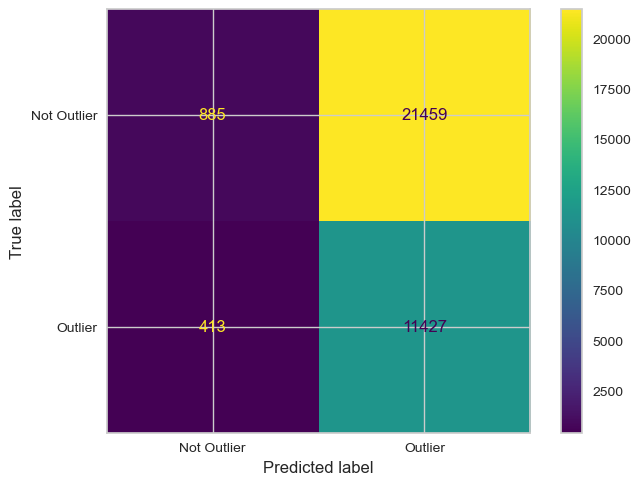

In [43]:
# your code here
lr_best = LogisticRegression(C=0.001, penalty='l1', solver="saga")
lr_best.fit(X_train_resampled, y_train_resampled)
y_pred_best_lr_test = lr_best.predict(X_test_scaled)
y_pred_best_lr_train = lr_best.predict(X_train_resampled)

conf_matrix_best_lr = confusion_matrix(y_test, y_pred_best_lr_test)

#Classification Report
print(classification_report(y_test, y_pred_best_lr_test, target_names=labels))

cm = confusion_matrix(y_test, y_pred_best_lr_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

So, our model does really well in the recall score for Outliers which is good but does very bad for Not Outliers. Making it feel like its not generalizing well to the data and overfitting for the Outliers. Our model essentially struggles with regular data points suggests a potential overfitting issue, particularly towards outliers.

### 4. Ada Boost Classifier

[[13036  9308]
 [ 4025  7815]]
              precision    recall  f1-score   support

 Not Outlier       0.76      0.58      0.66     22344
     Outlier       0.46      0.66      0.54     11840

    accuracy                           0.61     34184
   macro avg       0.61      0.62      0.60     34184
weighted avg       0.66      0.61      0.62     34184



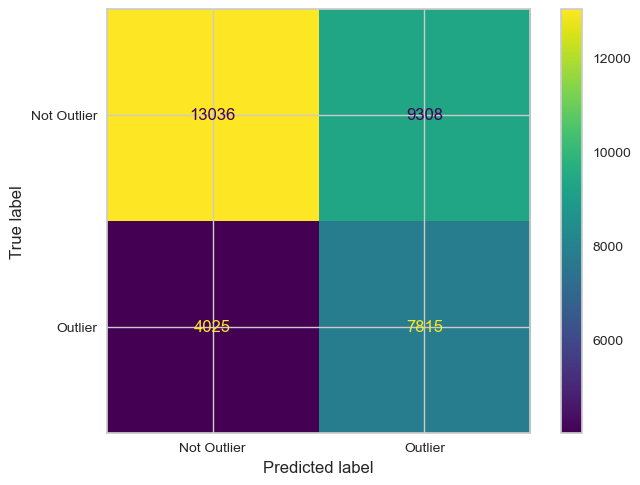

In [45]:
model_abc = AdaBoostClassifier()

#Fit the model
model_abc.fit(X_train_resampled, y_train_resampled)

#Predictions
y_pred_train_abc = model_abc.predict(X_train_resampled)
y_pred_test_abc = model_abc.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred_test_abc))

#Classification report
print(classification_report(y_test, y_pred_test_abc , target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_abc )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Adaboost does relatively well in looking at outliers and not outliers. Almost performing similarily to random forests. Will explore further after finetuning. 

For adaboost, we want to look at parameters learning rate, n_estiators, algorithm and scale_pos_weight. Based on the definitions that we know, smaller learning rate requires more weak learners, which is higher n_estimators, to achieve the same performance, which can improve the robustness of the model and prevent overfitting. Larger learning rate may lead to faster convergence but can also make the model more sensitive to noise. Adaboost has 2 algorithms, both are relatively the same, but SAMME.R handles continuous probability estimates and therefore can perform better at times. 

In [ ]:
# your code here
parameters = {'learning_rate': [0.1, 0.5, 1.0, 2.0], 'n_estimators': [50, 100, 150, 200], 'algorithm': ['SAMME', 'SAMME.R']}

# Step 2: Initialize a GridSearchCV object by passing your abc model, parameters and cv=10
model_ada_grid_search = GridSearchCV(model_abc, param_grid=parameters, cv=5, scoring='recall_micro')

# Step 3: Train the GridSearchCV (it will build multiply models and return the best)
model_ada_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_ada_grid_search.best_params_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 150}


              precision    recall  f1-score   support

 Not Outlier       0.76      0.58      0.66     22344
     Outlier       0.46      0.66      0.54     11840

    accuracy                           0.61     34184
   macro avg       0.61      0.62      0.60     34184
weighted avg       0.66      0.61      0.62     34184



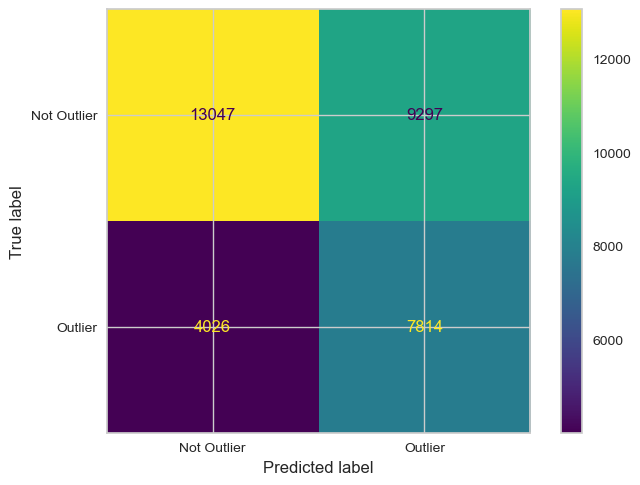

In [46]:
#using chosen parameters
abc_best = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.5, n_estimators= 150)

#Fit the model
abc_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_abc_best = abc_best.predict(X_train_resampled)
y_pred_test_abc_best = abc_best.predict(X_test_scaled)

#Classification Report
print(classification_report(y_test, y_pred_test_abc_best, target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_abc_best )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

After finetuning, we still see the same recall scores. I think with some more revision we would revisit some feature selection feature selection. I think with more time we would work on tuning hyperparameters using more sophisticated optimization techniques and or exploring a wider range of values, but our hyperparameter tuning for this already took 45 ish minutes so we will explore if we had more time. 

### 5. New Model: XGBoost
- XGBoost, Extreme Gradient Boosting, provides a parallel tree boosting (also known as GBDT, GBM) that is designed for maximum speed and model performance. XGBoost uses the gradient boosting decision tree algorithm where it creates new models that predict the residuals or errors of prior models and then added together to make the final prediction.

Reference: https://xgboost.readthedocs.io/en/stable/

[[17685  4659]
 [ 8868  2972]]
              precision    recall  f1-score   support

 Not Outlier       0.67      0.79      0.72     22344
     Outlier       0.39      0.25      0.31     11840

    accuracy                           0.60     34184
   macro avg       0.53      0.52      0.51     34184
weighted avg       0.57      0.60      0.58     34184



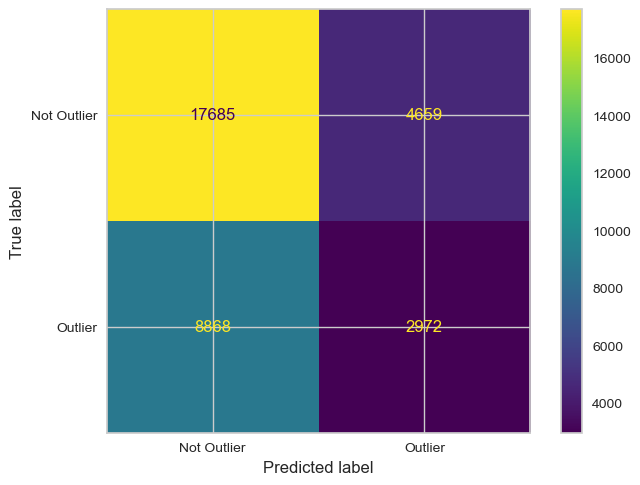

In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Create the XGBoost classifier
model_xgb = XGBClassifier()

# Fit the model
model_xgb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_train_xgb = model_xgb.predict(X_train_resampled)
y_pred_test_xgb = model_xgb.predict(X_test)

# Confusion matrix
print(confusion_matrix(y_test, y_pred_test_xgb))

# Classification report
print(classification_report(y_test, y_pred_test_xgb, target_names=labels))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Will be hypertuning more since it did not perform well in classifying outliers as much as we want it to. 

Parameters we would want to use since XGBooster gives higher accuracy is: 
scale_pos_weight: since our data is locating outliers, we would want to set scale_pos_weight to a value greater than 1 can give more importance to the minority class (outliers), which in turn would help the model to better capture their patterns
objective: 'binary:logistic', since we want to detect outliers, we are thinking of using an objective function that penalizes errors differently for outliers and normal instances
max_depth/min_child_weight: since we want to capture outliers, we want something that can lead to deeper and more complex trees, which may better capture the patterns of outliers

In [ ]:
# Define the XGBoost classifier with the chosen parameters
model_xgb = XGBClassifier()

parameters = {
    'objective': ['binary:logistic'],  
    'scale_pos_weight': [2, 5, 7, 10],  
    'max_depth': [2, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],  
    'n_estimators': [50, 100, 200]
}
# Initialize
model_xgb_grid_search = GridSearchCV(model_xgb, param_grid=parameters, cv=5, scoring='recall_micro')

# Train
model_xgb_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_xgb_grid_search.best_params_)


{'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'binary:logistic', 'scale_pos_weight': 2}


              precision    recall  f1-score   support

 Not Outlier       0.67      0.87      0.76     22344
     Outlier       0.44      0.19      0.27     11840

    accuracy                           0.64     34184
   macro avg       0.56      0.53      0.51     34184
weighted avg       0.59      0.64      0.59     34184



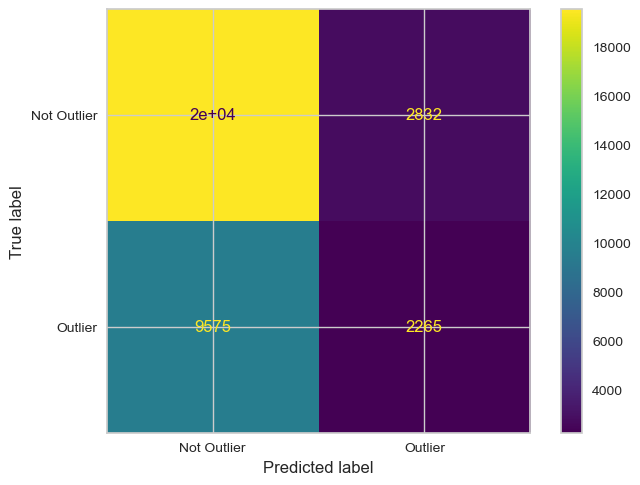

In [53]:
# your code here
xgb_best = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_best = xgb_best.predict(X_train_resampled)
y_pred_test_xgb_best = xgb_best.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test, y_pred_test_xgb_best, target_names=labels))

XGBoost after hypertuning increased its performance for categorizing outliers compared to before when we did not hypertune it. Recall before for not outliers was 0.84 and went to 0.73 and for outliers it went from 0.25 to 0.43. This make sense since the initial imbalance in the dataset, where outliers were the minority class, likely influenced the model's behavior, but I think that XGBoost probably generalizes the best to our data since it did improve its sensitivity without compromising their ability in classifying not outliers. 

Also, XGBoost has the capacity for handling imbalance datasets and capturing complex relationships and is known for robustness and generalizability. 
Based on the model that has done best, which at the moment is AdaBoost and XGBoost, we will apply this model for cold states and all states and then look at some feature importances.

### Looking at Power Transformer
Will be trying Power transformer as another scaler method. Power transformer can reduce the impact of outliers, but they can also be sensitive to extreme values, especially if the transformation exaggerates their effect. This may be good in our case since we do want to be able to observe the features that influence the model seeing if it can classify outlier or non-outliers. 

In [ ]:
#trying another scaler method
from sklearn.preprocessing import PowerTransformer

seed = 11

# standardizing the data 
X = warm_states[warm_states.columns.difference(['Is_Outlier'])]
y = warm_states['Is_Outlier']

#PowerTransformer object
power_transformer = PowerTransformer()

columns_to_transform = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the power transformer to the specified columns of the training data
power_transformer.fit(X_train[columns_to_transform])

# Transforming the train and test data based on the fitted transformer
X_train_power = X_train.copy()
X_train_power[columns_to_transform] = power_transformer.transform(X_train[columns_to_transform])

X_test_power = X_test.copy()
X_test_power[columns_to_transform] = power_transformer.transform(X_test[columns_to_transform])

print(y_test)

159917    0.0
111321    0.0
94295     0.0
211430    1.0
128254    0.0
         ... 
247109    0.0
132069    0.0
347042    0.0
485258    1.0
63303     0.0
Name: Is_Outlier, Length: 33513, dtype: float64


### XG Boost with Power Transformer

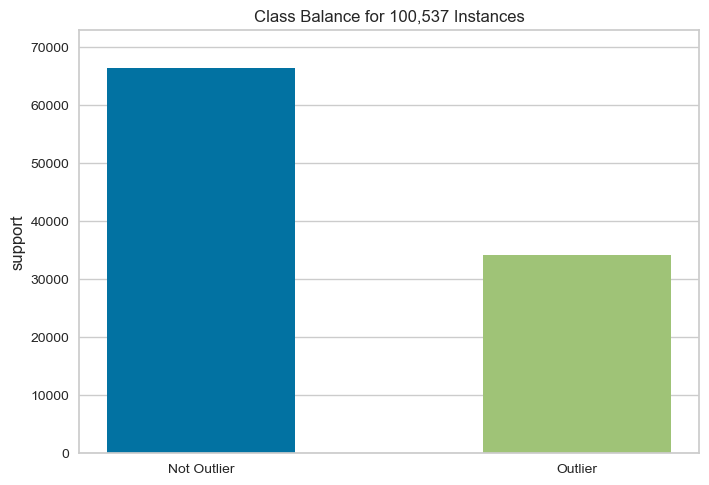

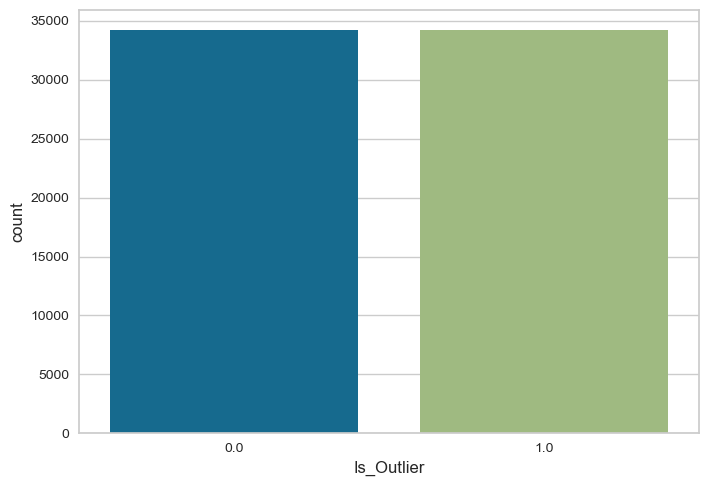

In [ ]:
#We want to undersample
# your code here

visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_power_resampled, y_train_power_resampled = rus.fit_resample(X_train_power, y_train)

# Visualize class balance after undersampling
sns.countplot(x=y_train_power_resampled, tick_label=labels)
plt.show()

              precision    recall  f1-score   support

 Not Outlier       0.80      0.59      0.68     22105
     Outlier       0.47      0.71      0.57     11408

    accuracy                           0.63     33513
   macro avg       0.63      0.65      0.62     33513
weighted avg       0.69      0.63      0.64     33513



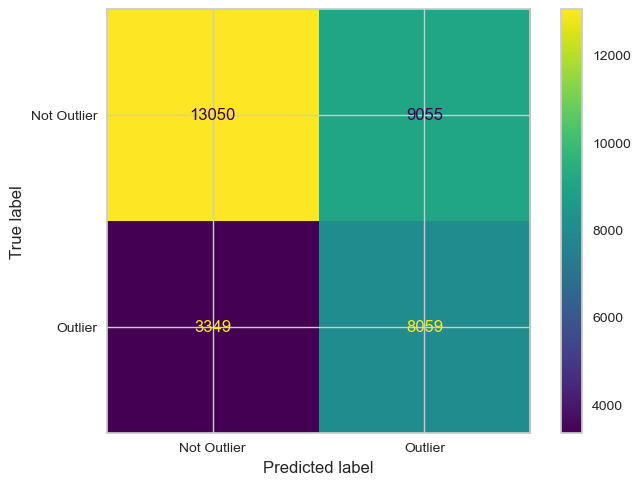

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# your code here
xgb_power = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_power.fit(X_train_power_resampled, y_train_power_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_power = xgb_power.predict(X_train_power_resampled)
y_pred_test_xgb_power = xgb_power.predict(X_test_power)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb_power)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels, cmap='Oranges')
disp.plot()

# Classification report
print(classification_report(y_test, y_pred_test_xgb_power, target_names=labels))

Using power transformer helped us get better recall scores for outlier but decreased for not outlier. Accuracy stayed the same. So, will not use this scaler for the next models, will use MinMaxScaler. 

___
## 4. Train/Test Splitting Data for *Cold States*

We want to also apply the AdaBoost and XGBoost to the cold states. By doing so we want to explore a distinct geographical region that, and hopefully see some unique insights that may differ from those observed in warm states. We will still be employing the same methodology that we did for warm states for the train test split for the same reasons. 

Repeating the same steps for warm states. 

- 1. Correlation Matrix
- 2. Scaling 
- 3. Resampling
- 4. XGBooster

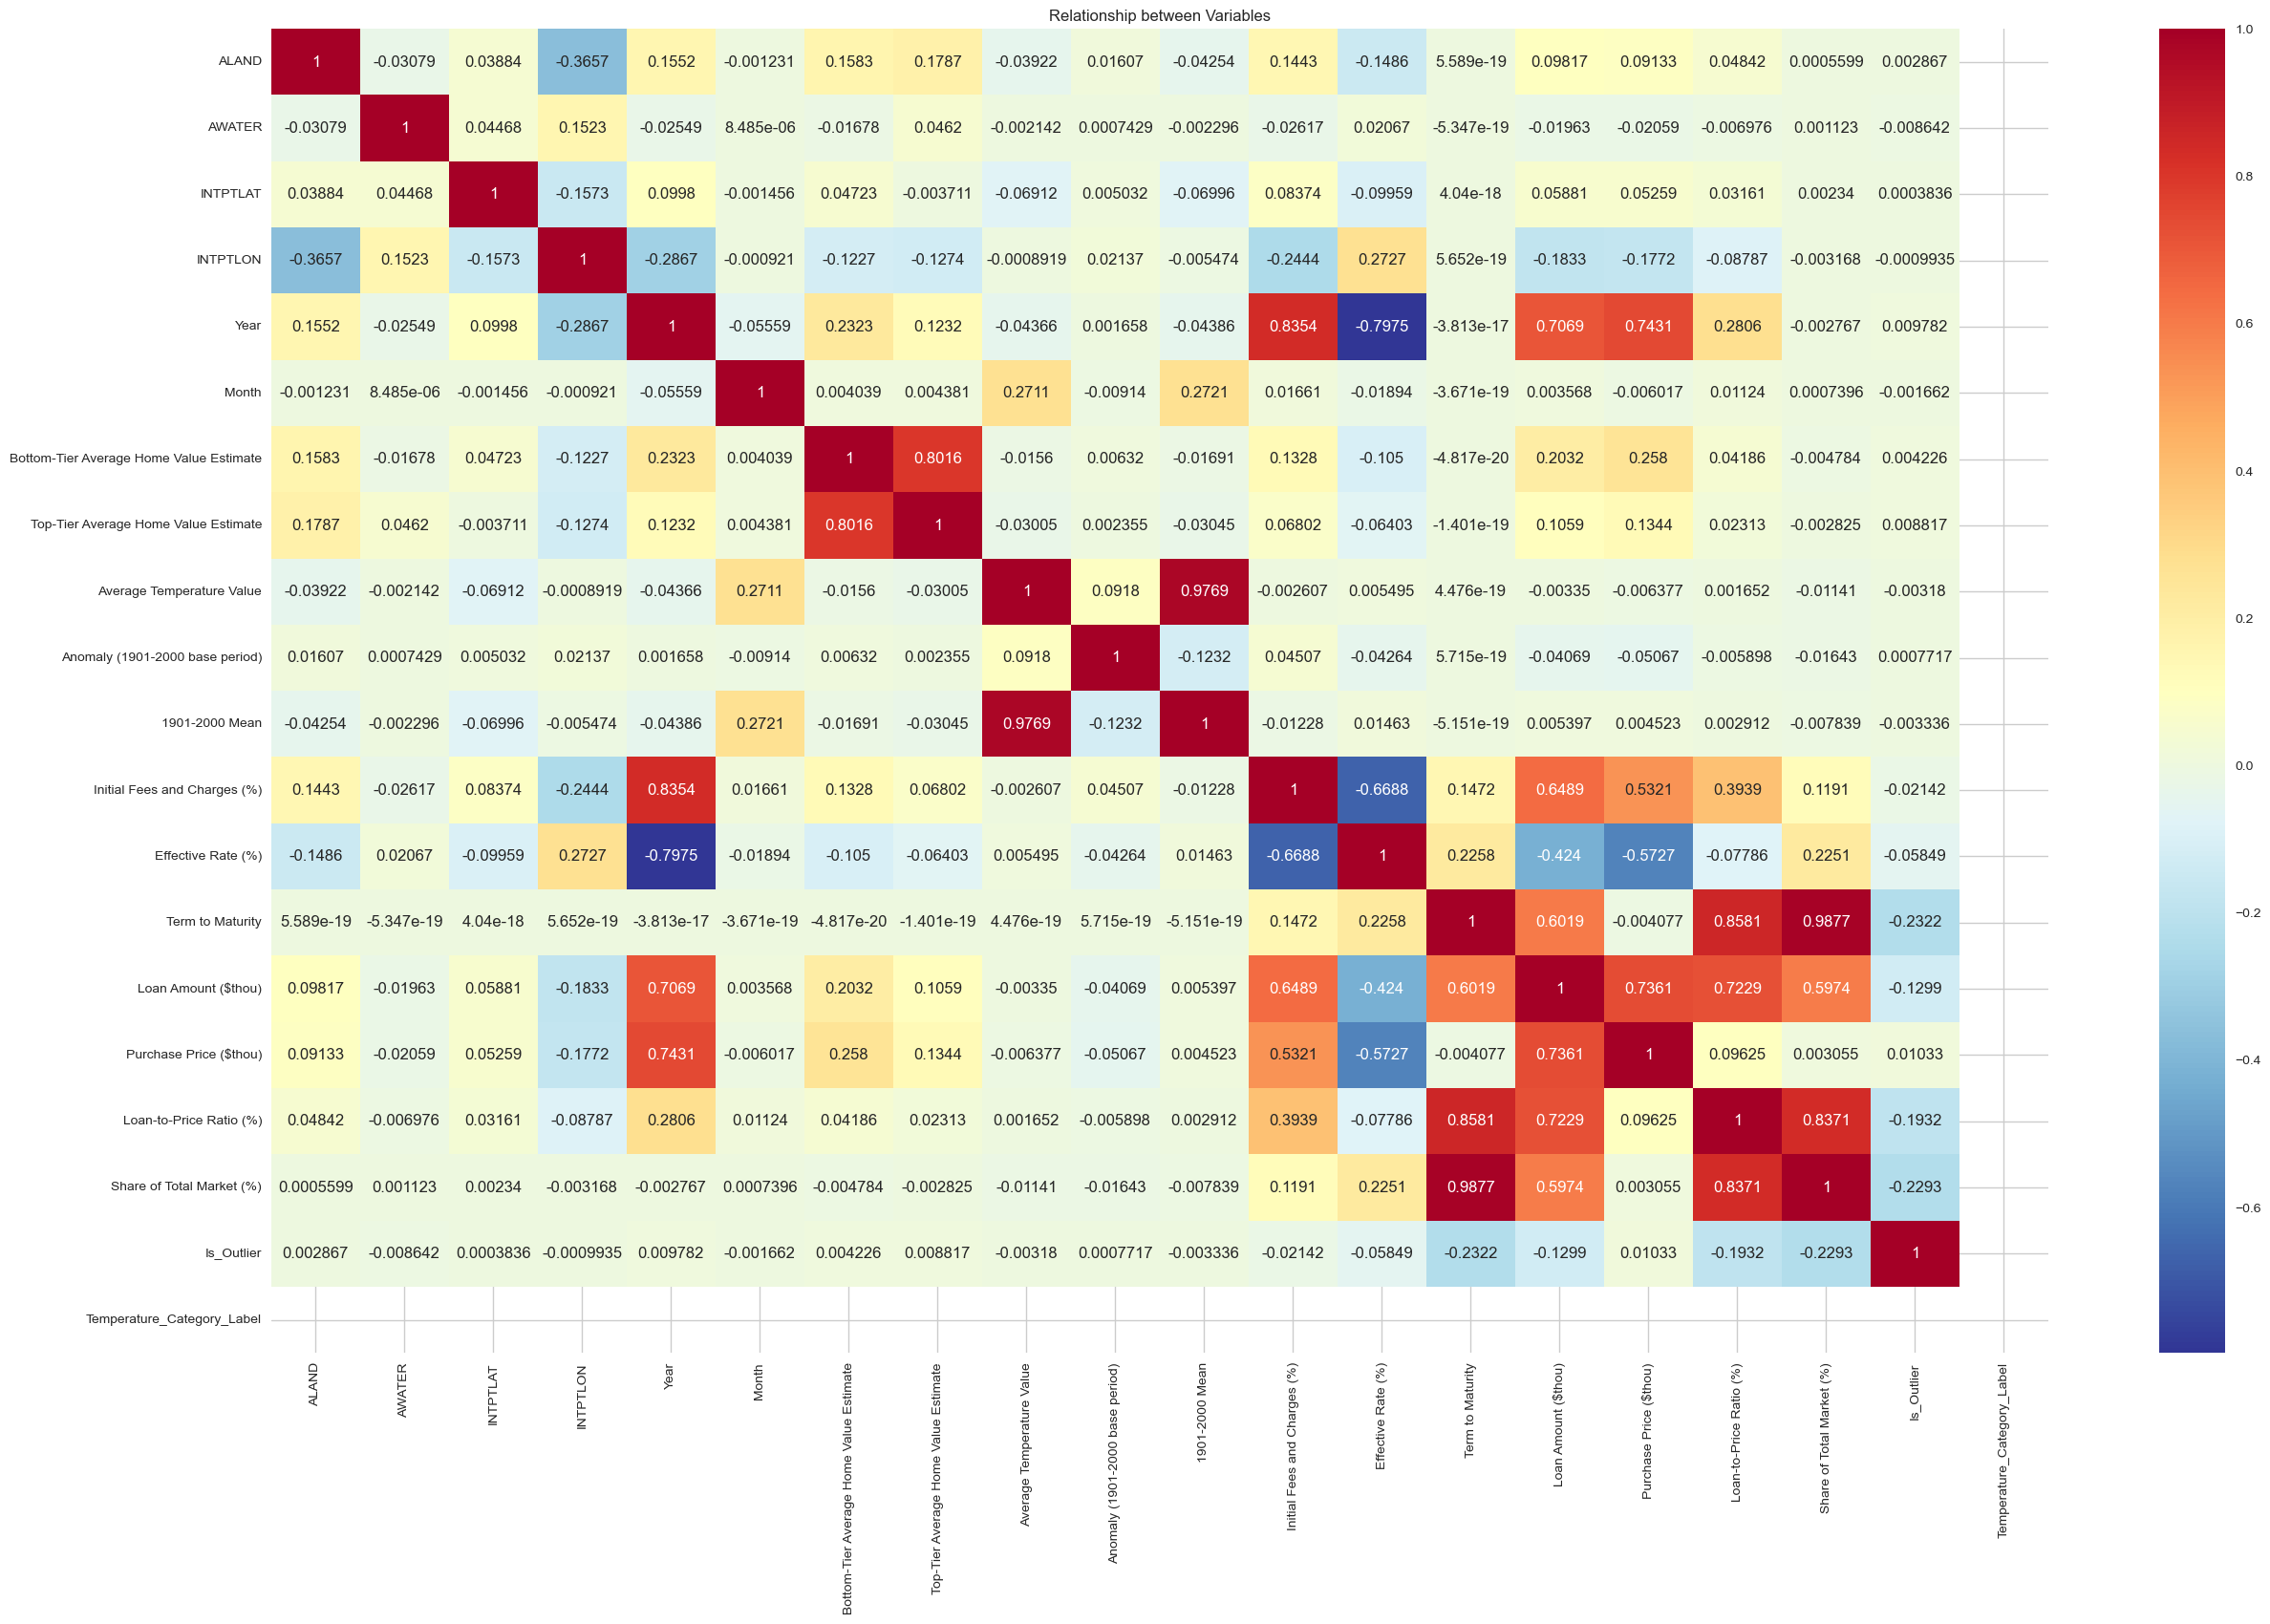

In [55]:
corr_matrix_cold = cold_states.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix_cold, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [56]:
#Need to drop highly correlated variables 
cold_states = cold_states.drop(columns=['Term to Maturity', 'Loan-to-Price Ratio (%)', '1901-2000 Mean'])

In [57]:
from sklearn.preprocessing import MinMaxScaler

#your code here
seed=11

#standardizing the cold_states 
X = cold_states[cold_states.columns.difference(['Is_Outlier'])]
y = cold_states['Is_Outlier']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train_cold, X_test_cold, y_train_cold, y_test_cold = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler to the specified columns of the training cold_states
scaler.fit(X_train_cold[columns_to_scale])

# Transforming the train and test cold_states based on the fitted scaler
X_train_cold_states = X_train_cold.copy()
X_train_cold_states[columns_to_scale] = scaler.transform(X_train_cold[columns_to_scale])

X_test_cold_states = X_test_cold.copy()
X_test_cold_states[columns_to_scale] = scaler.transform(X_test_cold[columns_to_scale])

print(y_test_cold)

22326     1.0
330615    0.0
11529     1.0
164667    0.0
343958    0.0
         ... 
435979    0.0
124238    0.0
255637    0.0
314968    1.0
424005    0.0
Name: Is_Outlier, Length: 11814, dtype: float64


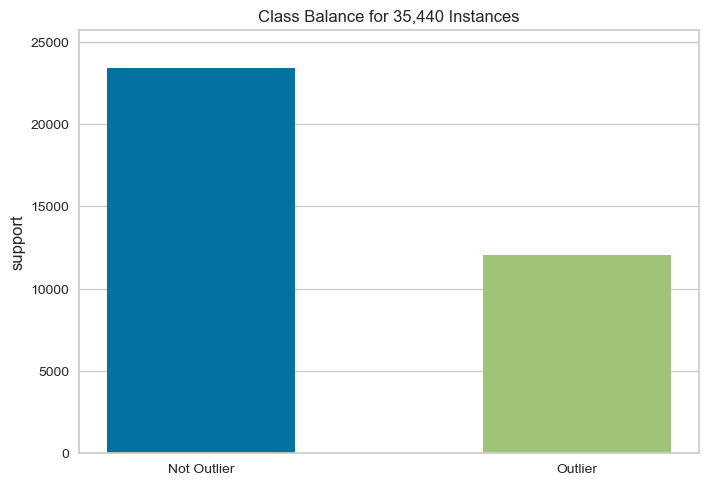

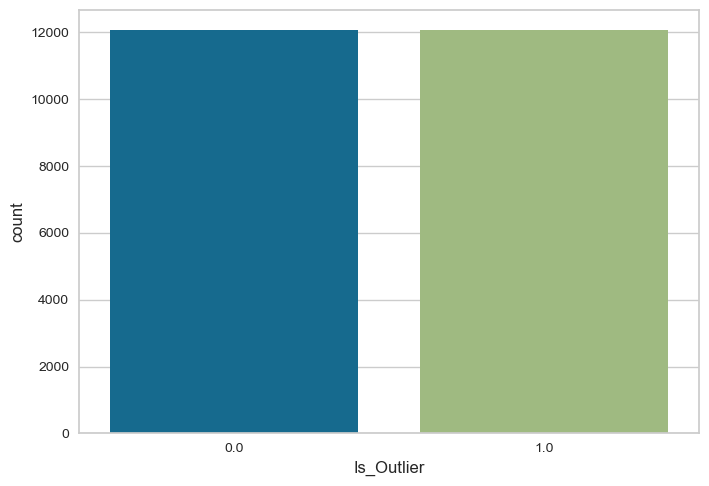

In [58]:
#We want to undersample
# your code here
labels = ["Not Outlier", "Outlier"]
visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train_cold)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_cold_resampled, y_train_cold_resampled = rus.fit_resample(X_train_cold_states, y_train_cold)

# Visualize class balance after undersampling
sns.countplot(x=y_train_cold_resampled, tick_label=labels)
plt.show()

              precision    recall  f1-score   support

 Not Outlier       0.78      0.58      0.66      7840
     Outlier       0.45      0.67      0.54      3974

    accuracy                           0.61     11814
   macro avg       0.61      0.62      0.60     11814
weighted avg       0.67      0.61      0.62     11814



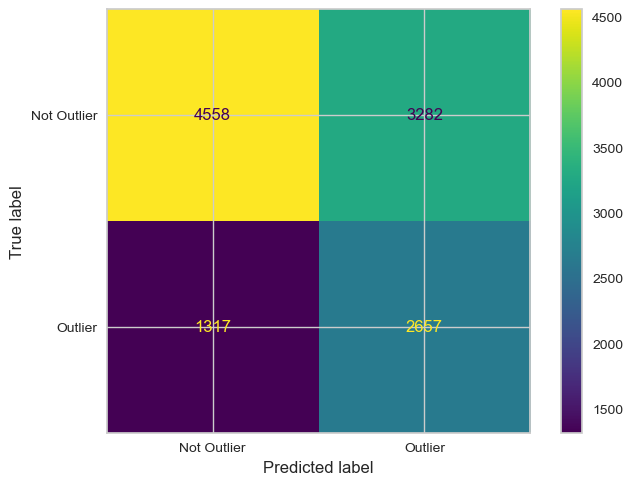

In [59]:
#using chosen parameters
abc_best_cold = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.5, n_estimators= 150)

#Fit the model
abc_best_cold.fit(X_train_cold_resampled, y_train_cold_resampled)

#Evaluate the model, Predictions
y_pred_train_abc_cold = abc_best_cold.predict(X_train_cold_resampled)
y_pred_test_abc_cold = abc_best_cold.predict(X_test_cold_states)

# Confusion matrix
cm = confusion_matrix(y_test_cold, y_pred_test_abc_cold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_cold, y_pred_test_abc_cold, target_names=labels))

The model performs moderately well for predicting outliers better than not outliers. This actually performs relatively the same as warm states. 

              precision    recall  f1-score   support

 Not Outlier       0.81      0.60      0.69      7840
     Outlier       0.48      0.72      0.57      3974

    accuracy                           0.64     11814
   macro avg       0.64      0.66      0.63     11814
weighted avg       0.70      0.64      0.65     11814



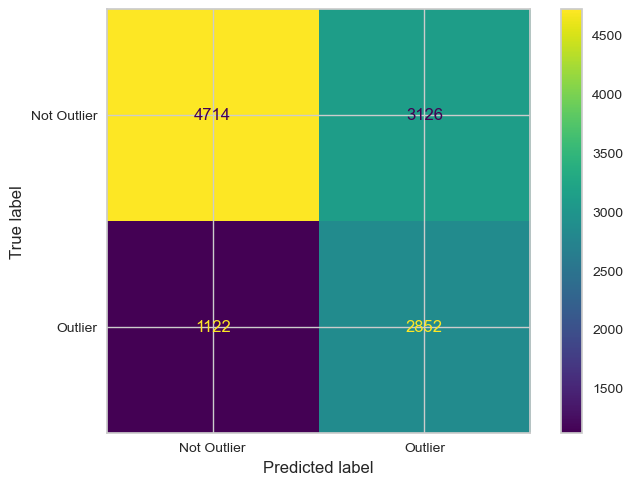

In [60]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# your code here
xgb_best_cold = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_best_cold.fit(X_train_cold_resampled, y_train_cold_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_best_cold = xgb_best_cold.predict(X_train_cold_resampled)
y_pred_test_xgb_best_cold = xgb_best_cold.predict(X_test_cold_states)

# Confusion matrix
cm = confusion_matrix(y_test_cold, y_pred_test_xgb_best_cold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_cold, y_pred_test_xgb_best_cold, target_names=labels))

This model actually performs better for cold states that warm states. They are able to capture classifying outliers better than not outliers for cold states compared to warm states. Possibly cold states could be exhibiting distinct environmental conditions sensitivities, particularily bigger temperature anomalies from year to hear. These variations could influence the relevance and importance of features which impact model performance. 

___
## 5. Train/Test Splitting Data for *All States*

We are still going to do the same train and test splits because we want out model to use all historical data for training, we wanted to maximize the amount of information that our model could learn from. Given the performance of AdaBoost and XGBoost in both warm and cold states, we want to see the models performance on all states. This decision reflects our desire to capitalize on the strengths exhibited by these models across different environmental conditions. By using the entirety of our data, we want to be able to discover some valuable patterns and relationships that are limited to just regional distinctions.

We will look into feature importances revealed by these models when applied to the entire dataset. This hopefully will drive our models' predictive capabilities and offer some insights on identifying counties that deviate from the norm, and also align with our hypothesis.

Repeating the same steps for warm and cold states. 

- 1. Correlation Matrix
- 2. Scaling 
- 3. Resampling
- 4. XGBooster

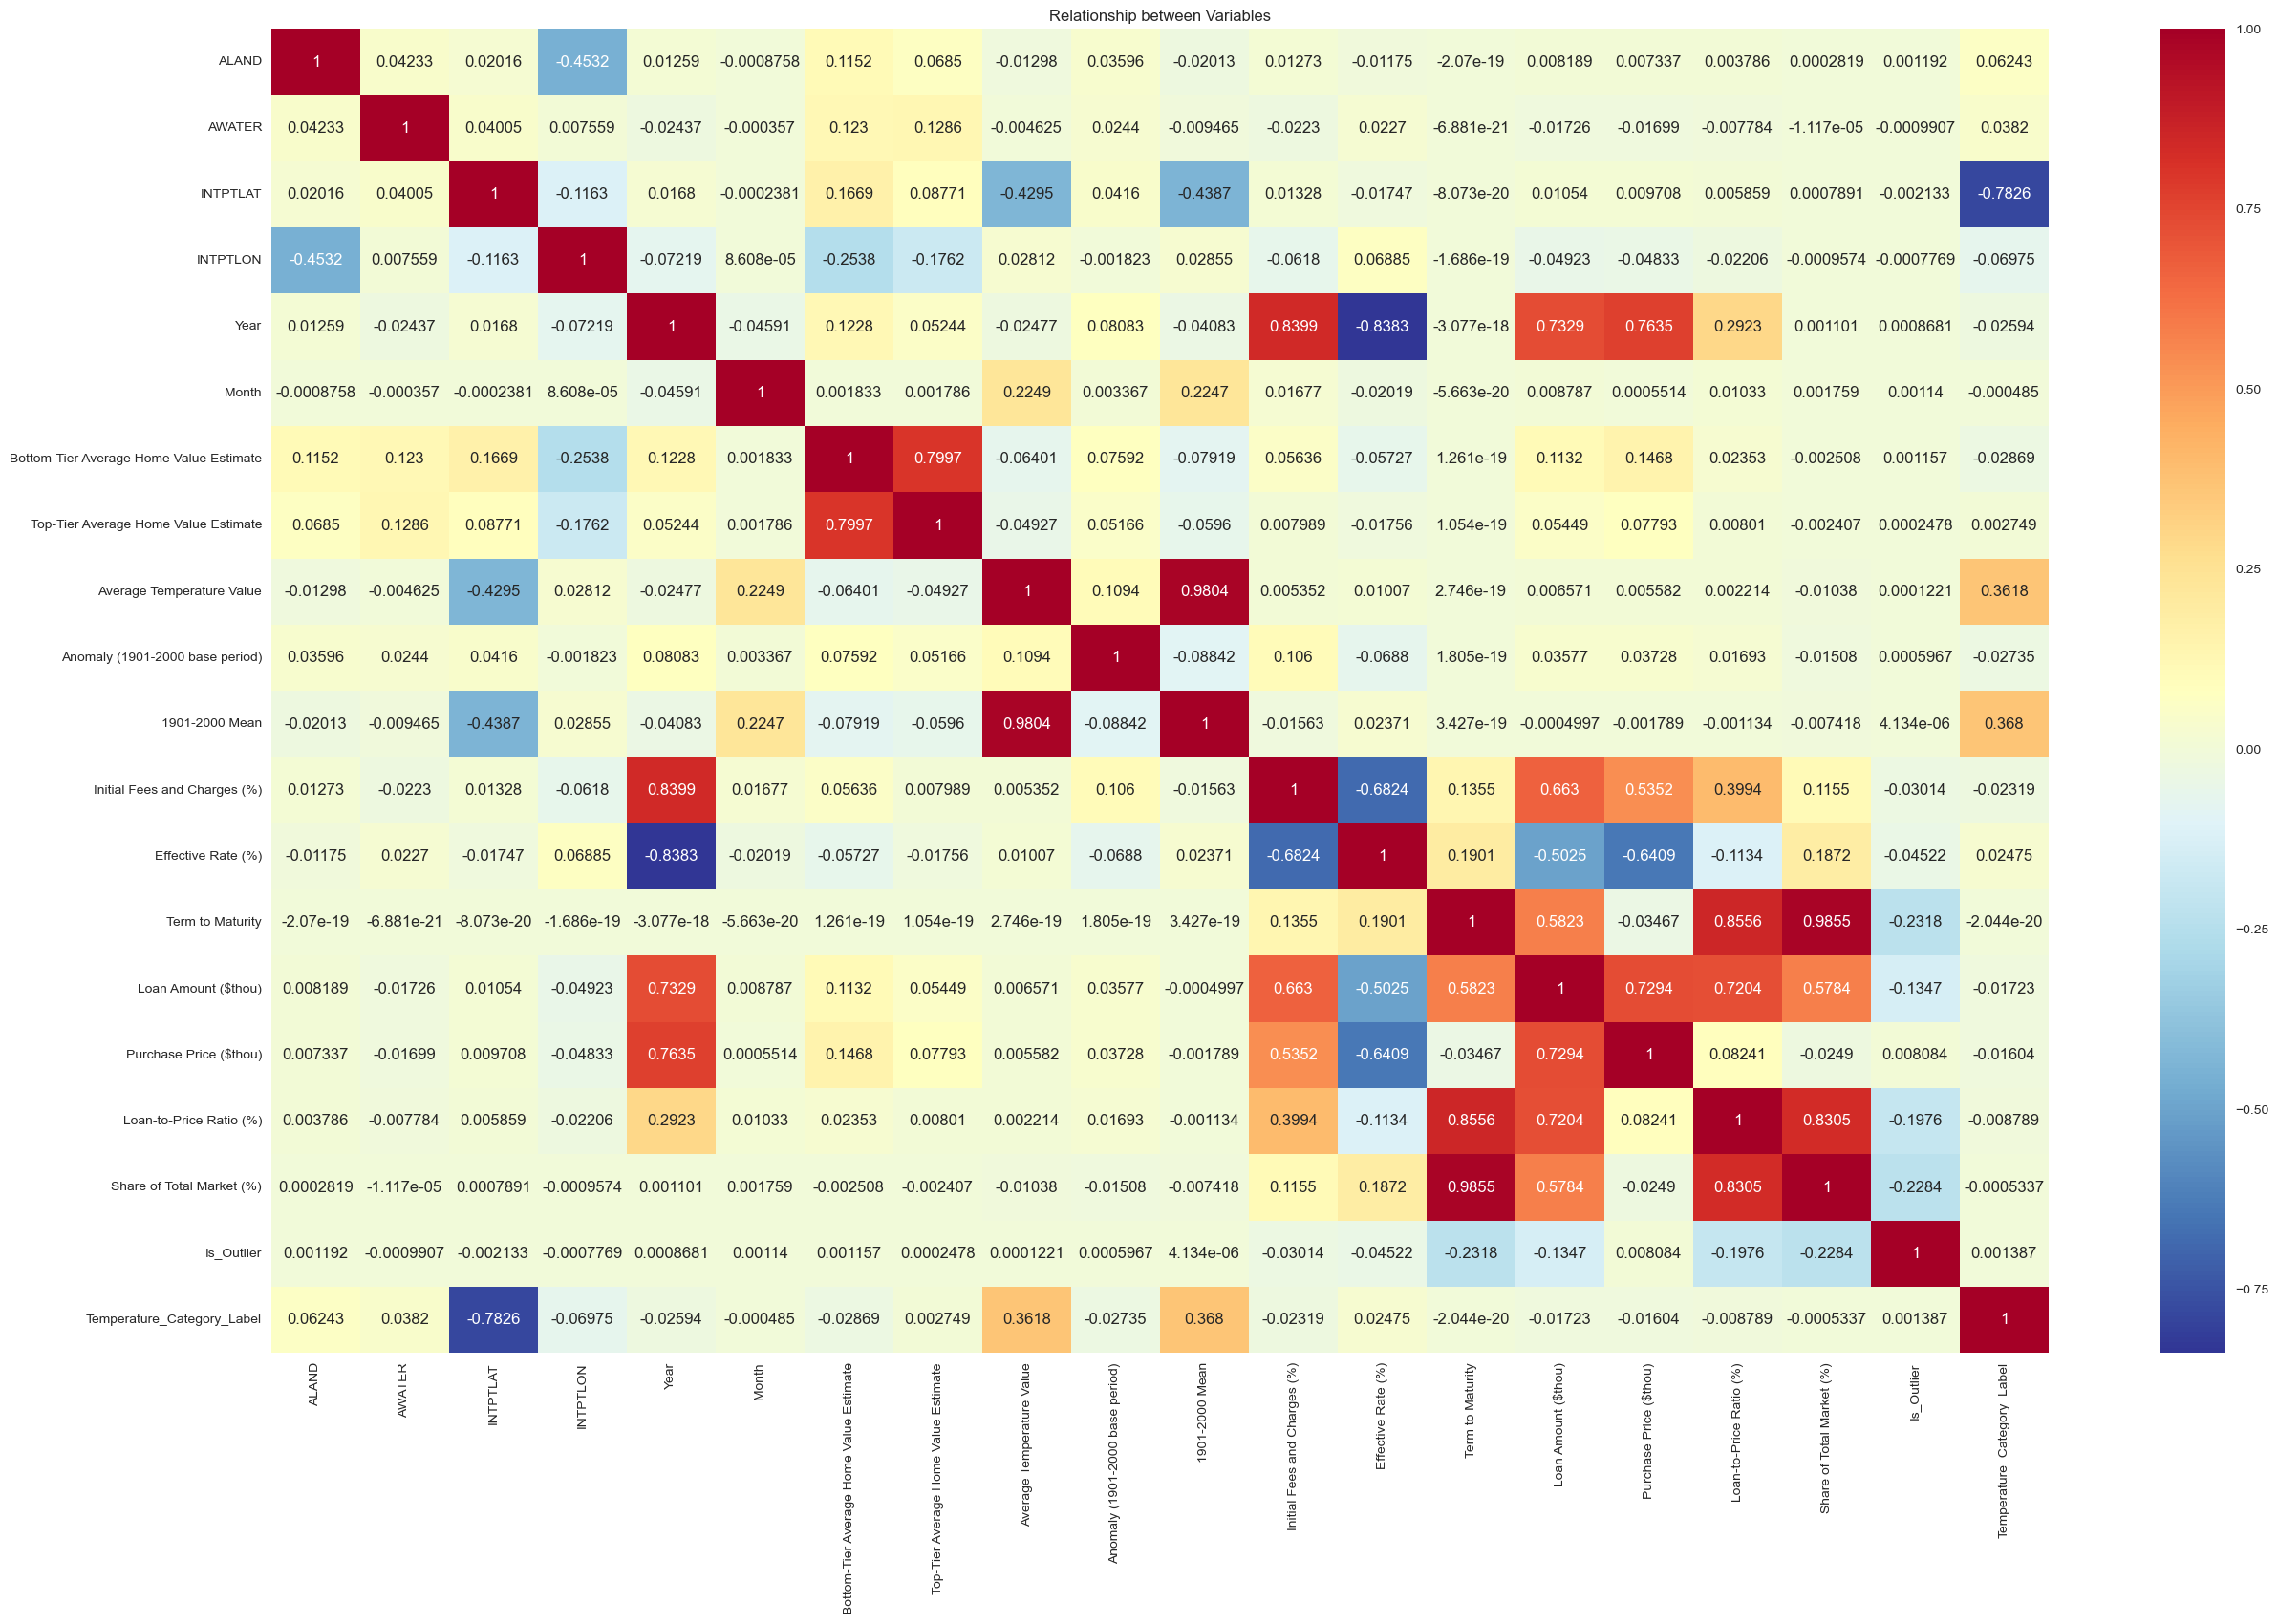

In [61]:
corr_matrix_all = data.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix_all, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [62]:
#Need to drop highly correlated variables 
data = data.drop(columns=['Term to Maturity', 'Loan-to-Price Ratio (%)', '1901-2000 Mean'])

In [63]:
from sklearn.preprocessing import MinMaxScaler

#your code here
seed=11

#standardizing the data 
X = data[data.columns.difference(['Is_Outlier'])]
y = data['Is_Outlier']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler to the specified columns of the training data
scaler.fit(X_train_all[columns_to_scale])

# Transforming the train and test data based on the fitted scaler
X_train_all_states = X_train_all.copy()
X_train_all_states[columns_to_scale] = scaler.transform(X_train_all[columns_to_scale])

X_test_all_states = X_test_all.copy()
X_test_all_states[columns_to_scale] = scaler.transform(X_test_all[columns_to_scale])

print(y_test_all)

417200    0.0
391878    0.0
342082    0.0
69162     0.0
463507    1.0
         ... 
115776    0.0
7306      1.0
371931    0.0
23020     0.0
506470    0.0
Name: Is_Outlier, Length: 126088, dtype: float64


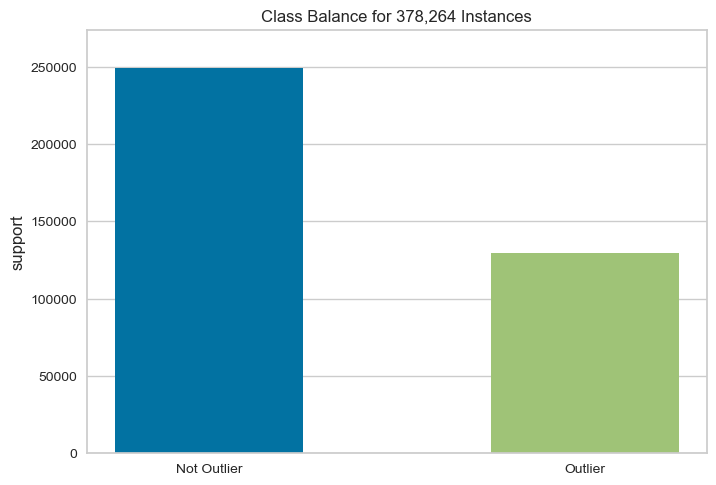

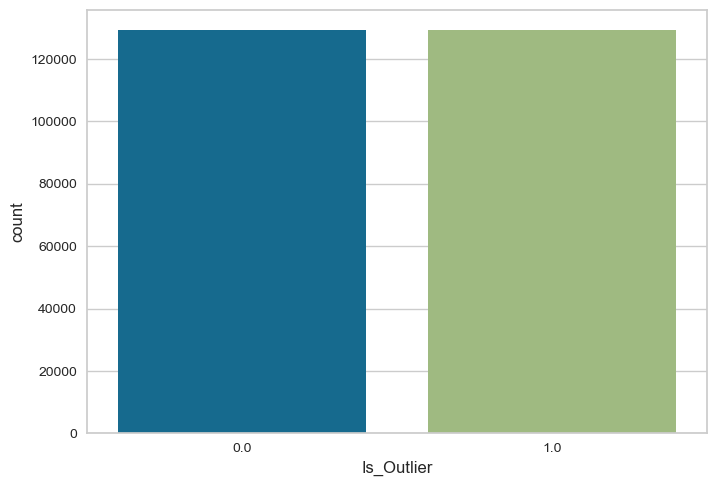

In [64]:
#We want to undersample
# your code here
labels = ["Not Outlier", "Outlier"]
visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train_all)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_all_resampled, y_train_all_resampled = rus.fit_resample(X_train_all_states, y_train_all)

# Visualize class balance after undersampling
sns.countplot(x=y_train_all_resampled, tick_label=labels)
plt.show()

              precision    recall  f1-score   support

 Not Outlier       0.77      0.59      0.66     82844
     Outlier       0.45      0.66      0.54     43244

    accuracy                           0.61    126088
   macro avg       0.61      0.62      0.60    126088
weighted avg       0.66      0.61      0.62    126088



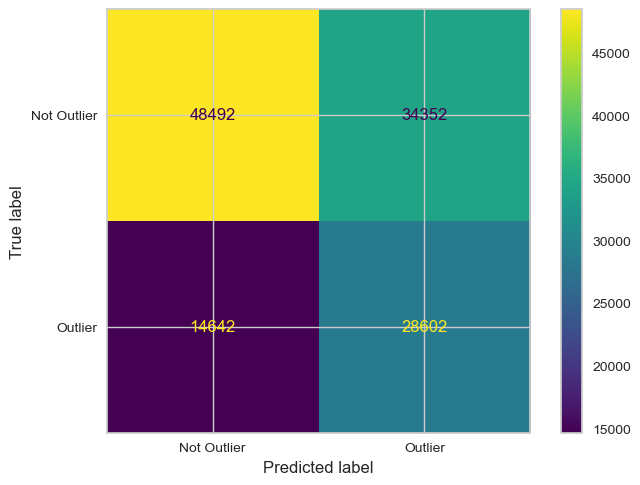

In [65]:
#using chosen parameters
abc_best_all = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.5, n_estimators= 150)

#Fit the model
abc_best_all.fit(X_train_all_resampled, y_train_all_resampled)

#Evaluate the model, Predictions
y_pred_train_abc_all = abc_best_all.predict(X_train_all_resampled)
y_pred_test_abc_all = abc_best_all.predict(X_test_all_states)

# Confusion matrix
cm = confusion_matrix(y_test_all, y_pred_test_abc_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_all, y_pred_test_abc_all, target_names=labels))

Again, this model does well looking at all the states data which is good! Recall scores are higher for outlier than not outliers, but this follows in the same suit for warm and cold states. So will be exploring more after looking at XGBoost. 


              precision    recall  f1-score   support

 Not Outlier       0.80      0.57      0.67     82844
     Outlier       0.47      0.73      0.57     43244

    accuracy                           0.63    126088
   macro avg       0.64      0.65      0.62    126088
weighted avg       0.69      0.63      0.64    126088



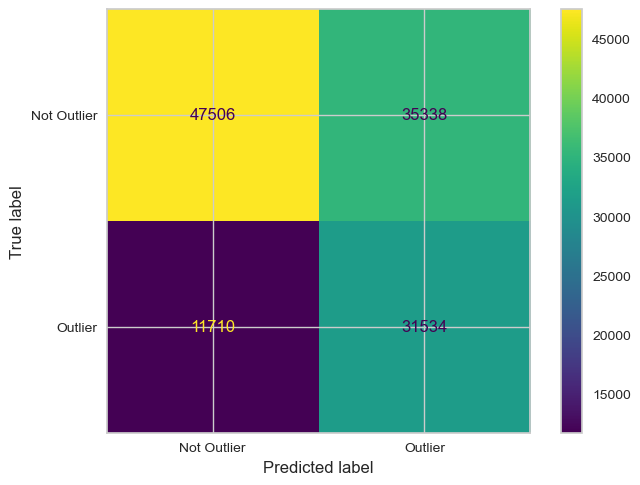

In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# your code here
xgb_best_all = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_best_all.fit(X_train_all_resampled, y_train_all_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_best_all = xgb_best_all.predict(X_train_all_resampled)
y_pred_test_xgb_best_all = xgb_best_all.predict(X_test_all_states)

# Confusion matrix
cm = confusion_matrix(y_test_all, y_pred_test_xgb_best_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_all, y_pred_test_xgb_best_all, target_names=labels))


This model does really well in classifying outliers, which is good because since we are looking at all the states without regional differentiations showing that our model  is able to identify features indicative of outliers, irrespective of specific regional characteristics. I think it also shows that the model does not need to rely on regional differentiations to do outlier classification which could mean that regions with similar annual temperatures may not be part of the feature importance. Will look at next. 

___
## 6. Evaluation and Interpretation


#### *Warm States*

In [69]:
labels = ["Not Outlier", "Outlier"]

recall_scores_NB_7= recall_score(y_test, y_test_pred_NB, average=None)
recall_scores_lr_7 = recall_score(y_test, y_pred_best_lr_test, average=None)
recall_scores_rfc_7 = recall_score(y_test, y_pred_test_rfc_best, average=None)
recall_scores_abc_7 = recall_score(y_test, y_pred_test_abc_best, average=None)
recall_scores_xg_7 = recall_score(y_test, y_pred_test_xgb_best, average=None)

data_metric_class = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Ada Boost', 'XGBoost']
}

# Add recall scores for each class for each model to the dictionary
for i, class_name in enumerate(labels): 
    data_metric_class[class_name] = [
        recall_scores_NB_7[i],
        recall_scores_lr_7[i],
        recall_scores_rfc_7[i],
        recall_scores_abc_7[i],
        recall_scores_xg_7[i]
    ]

# Convert the dictionary to a DataFrame
df_recall_scores_class = pd.DataFrame(data_metric_class)

# Display the DataFrame
print('For Warm States')
print(df_recall_scores_class)

For Warm States
                 Model  Not Outlier   Outlier
0          Naive Bayes     0.923067  0.077365
1  Logistic Regression     0.039608  0.965118
2        Random Forest     0.773362  0.369595
3            Ada Boost     0.583915  0.659966
4              XGBoost     0.873255  0.191301


#### *Cold States*

In [71]:

# Define class labels
labels = ["Not Outlier", "Outlier"]

recall_scores_abc_7_cold = recall_score(y_test_cold, y_pred_test_abc_cold, average=None)
recall_scores_xg_7_cold = recall_score(y_test_cold, y_pred_test_xgb_best_cold, average=None)

data_metric_class_cold = {
    'Model': [ 'Ada Boost', 'XGBoost']
}

# Add recall scores for each class for each model to the dictionary
for i, class_name in enumerate(labels): 
    data_metric_class_cold[class_name] = [
        recall_scores_abc_7_cold[i],
        recall_scores_xg_7_cold[i]
    ]

# Convert the dictionary to a DataFrame
df_recall_scores_class_cold = pd.DataFrame(data_metric_class_cold)

# Display the DataFrame
print('For Warm States')
print(df_recall_scores_class_cold)


For Warm States
       Model  Not Outlier   Outlier
0  Ada Boost     0.581378  0.668596
1    XGBoost     0.601276  0.717665


#### *All States*

In [72]:
# Define class labels
labels = ["Not Outlier", "Outlier"]

recall_scores_abc_7_all = recall_score(y_test_all, y_pred_test_abc_all, average=None)
recall_scores_xg_7_all = recall_score(y_test_all, y_pred_test_xgb_best_all, average=None)

data_metric_class_all = {
    'Model': [ 'Ada Boost', 'XGBoost']
}

# Add recall scores for each class for each model to the dictionary
for i, class_name in enumerate(labels): 
    data_metric_class_all[class_name] = [
        recall_scores_abc_7_all[i],
        recall_scores_xg_7_all[i]
    ]

# Convert the dictionary to a DataFrame
df_recall_scores_class_all = pd.DataFrame(data_metric_class_all)

# Display the DataFrame
print('For All States')
print(df_recall_scores_class_all)

For All States
       Model  Not Outlier   Outlier
0  Ada Boost     0.585341  0.661410
1    XGBoost     0.573439  0.729211


### Interpretation 

Based on model performance, XG Boost is our preferred choice since it is able to detect outliers effectively while also considering feature importances. The XGBoost model has given us a reasonable performance for detecting outliers (Outlier score of 0.432591), but it also ensures that each feature contributes significantly to the model's performance, as indicated by its feature importances (look at the figure below).

Since wanted to prioritize outliers, we wanted to maximize recall for the outlier class. XGBoost's relatively high outlier score portrayed that it performs well in identifying outliers, while its feature importances ensure that each feature contributes to this task. 


Text(0.5, 1.0, 'XGBoost')

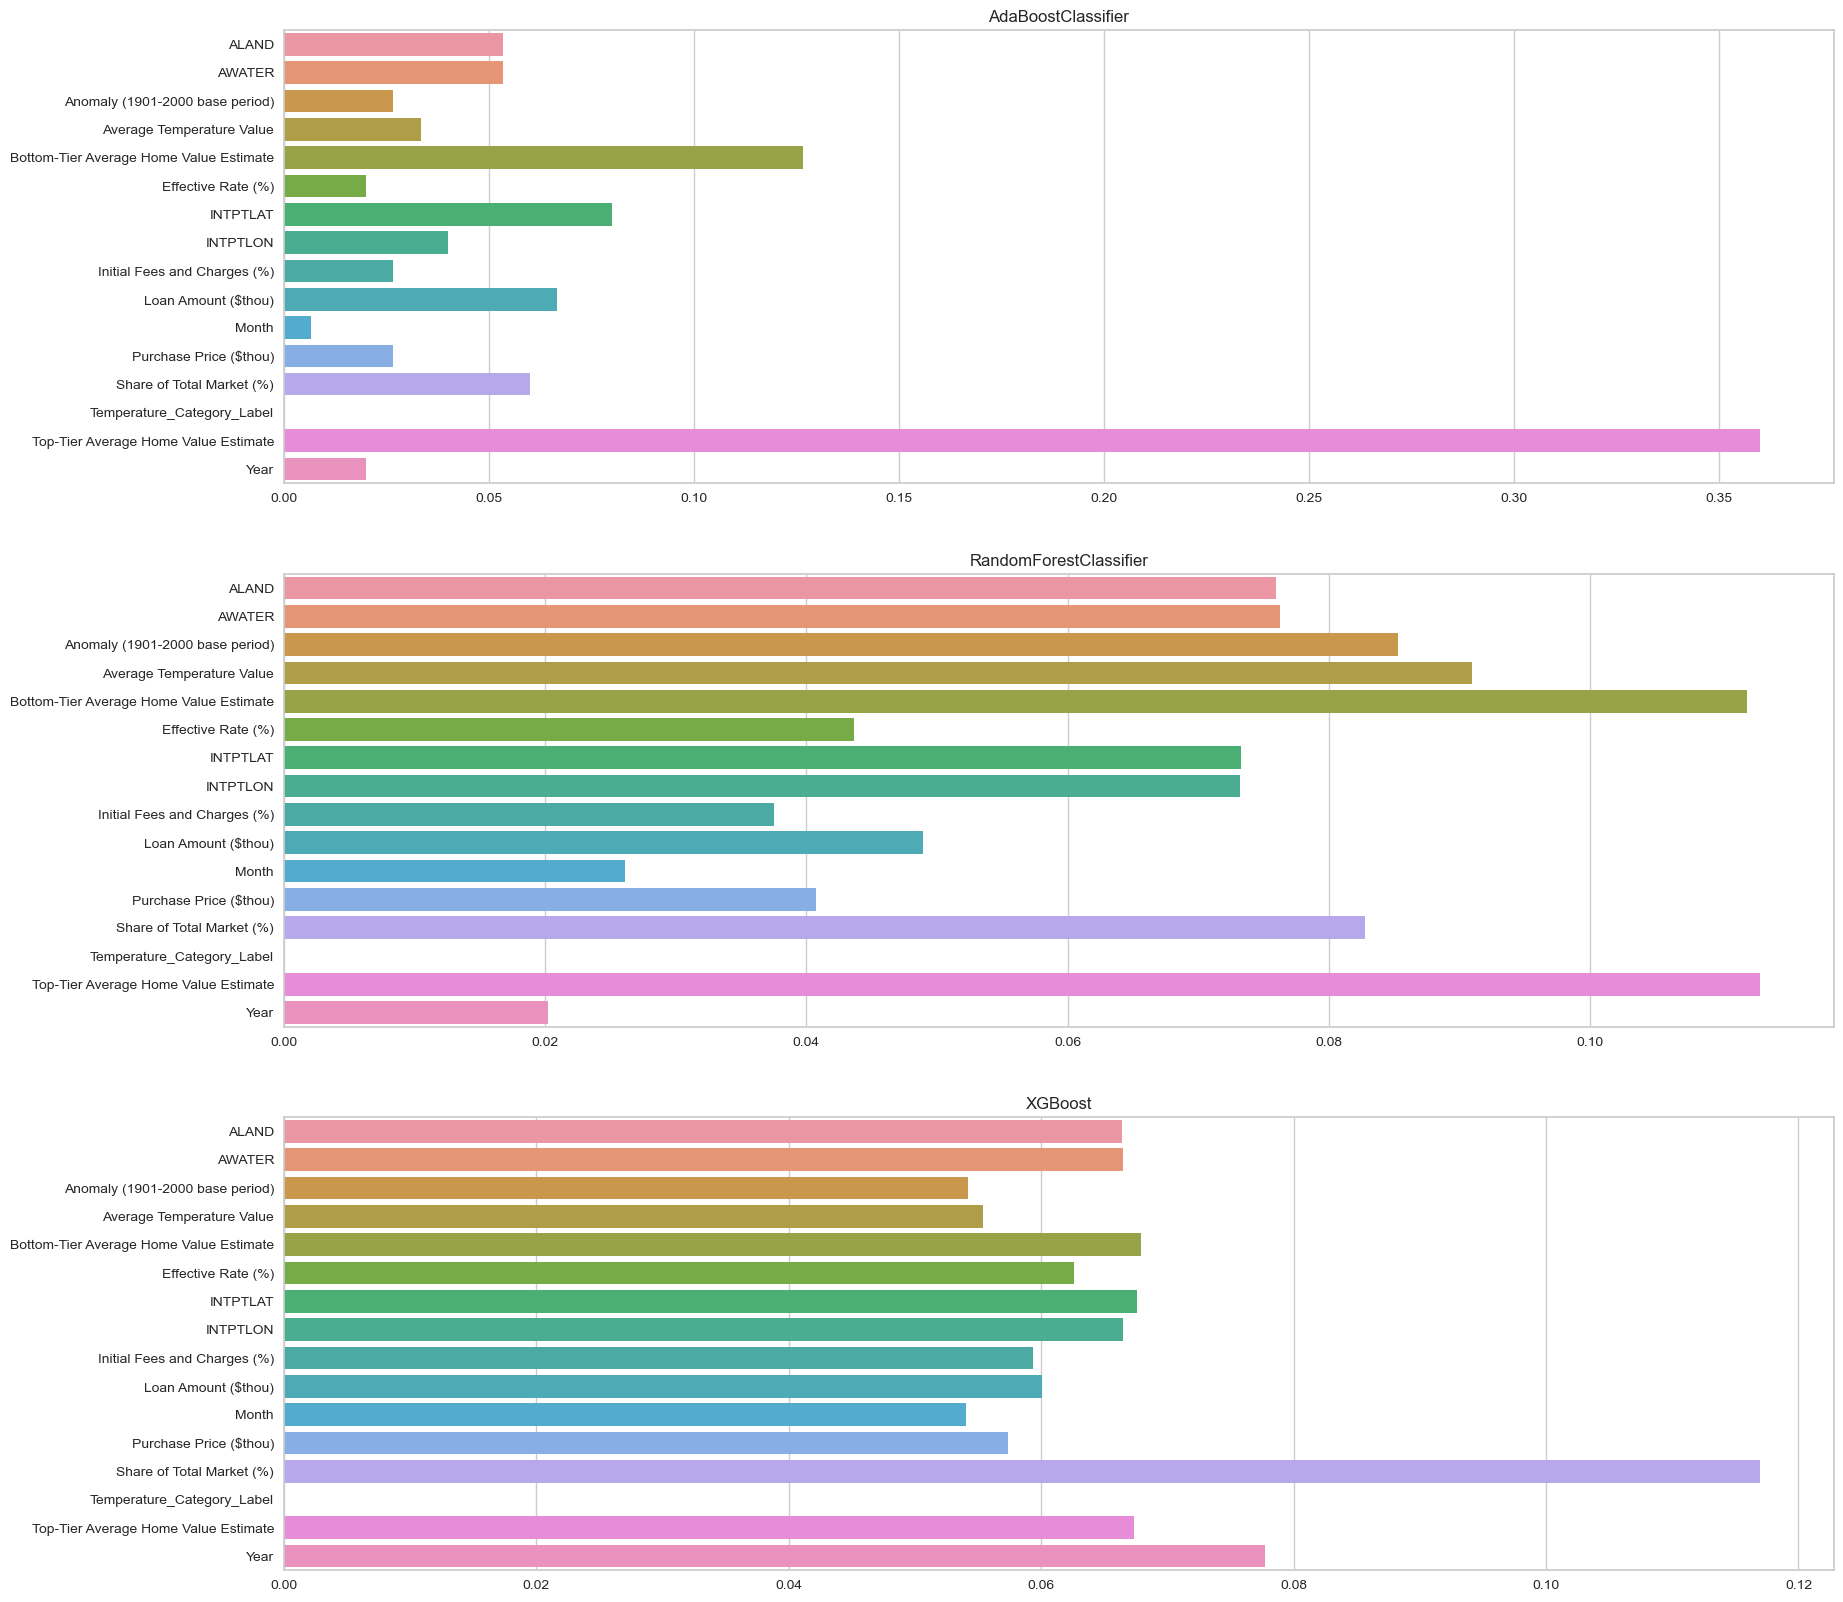

In [75]:
# your code here

fig, axes = plt.subplots(3, 1, figsize=(20,20))

# Plot 1: Warm States ABC
sns.barplot(x=abc_best.feature_importances_, y= X.columns ,  ax=axes[0])
axes[0].set_title('AdaBoostClassifier')
# Plot 2: Warm States RFC
sns.barplot(x=rfc_best.feature_importances_, y= X.columns, ax=axes[1])
axes[1].set_title('RandomForestClassifier')
# Plot 3: Warm States XGBoost
sns.barplot(x=xgb_best.feature_importances_, y= X.columns, ax=axes[2])
axes[2].set_title('XGBoost')

### *Cold States*

Text(0.5, 1.0, 'XGBoost')

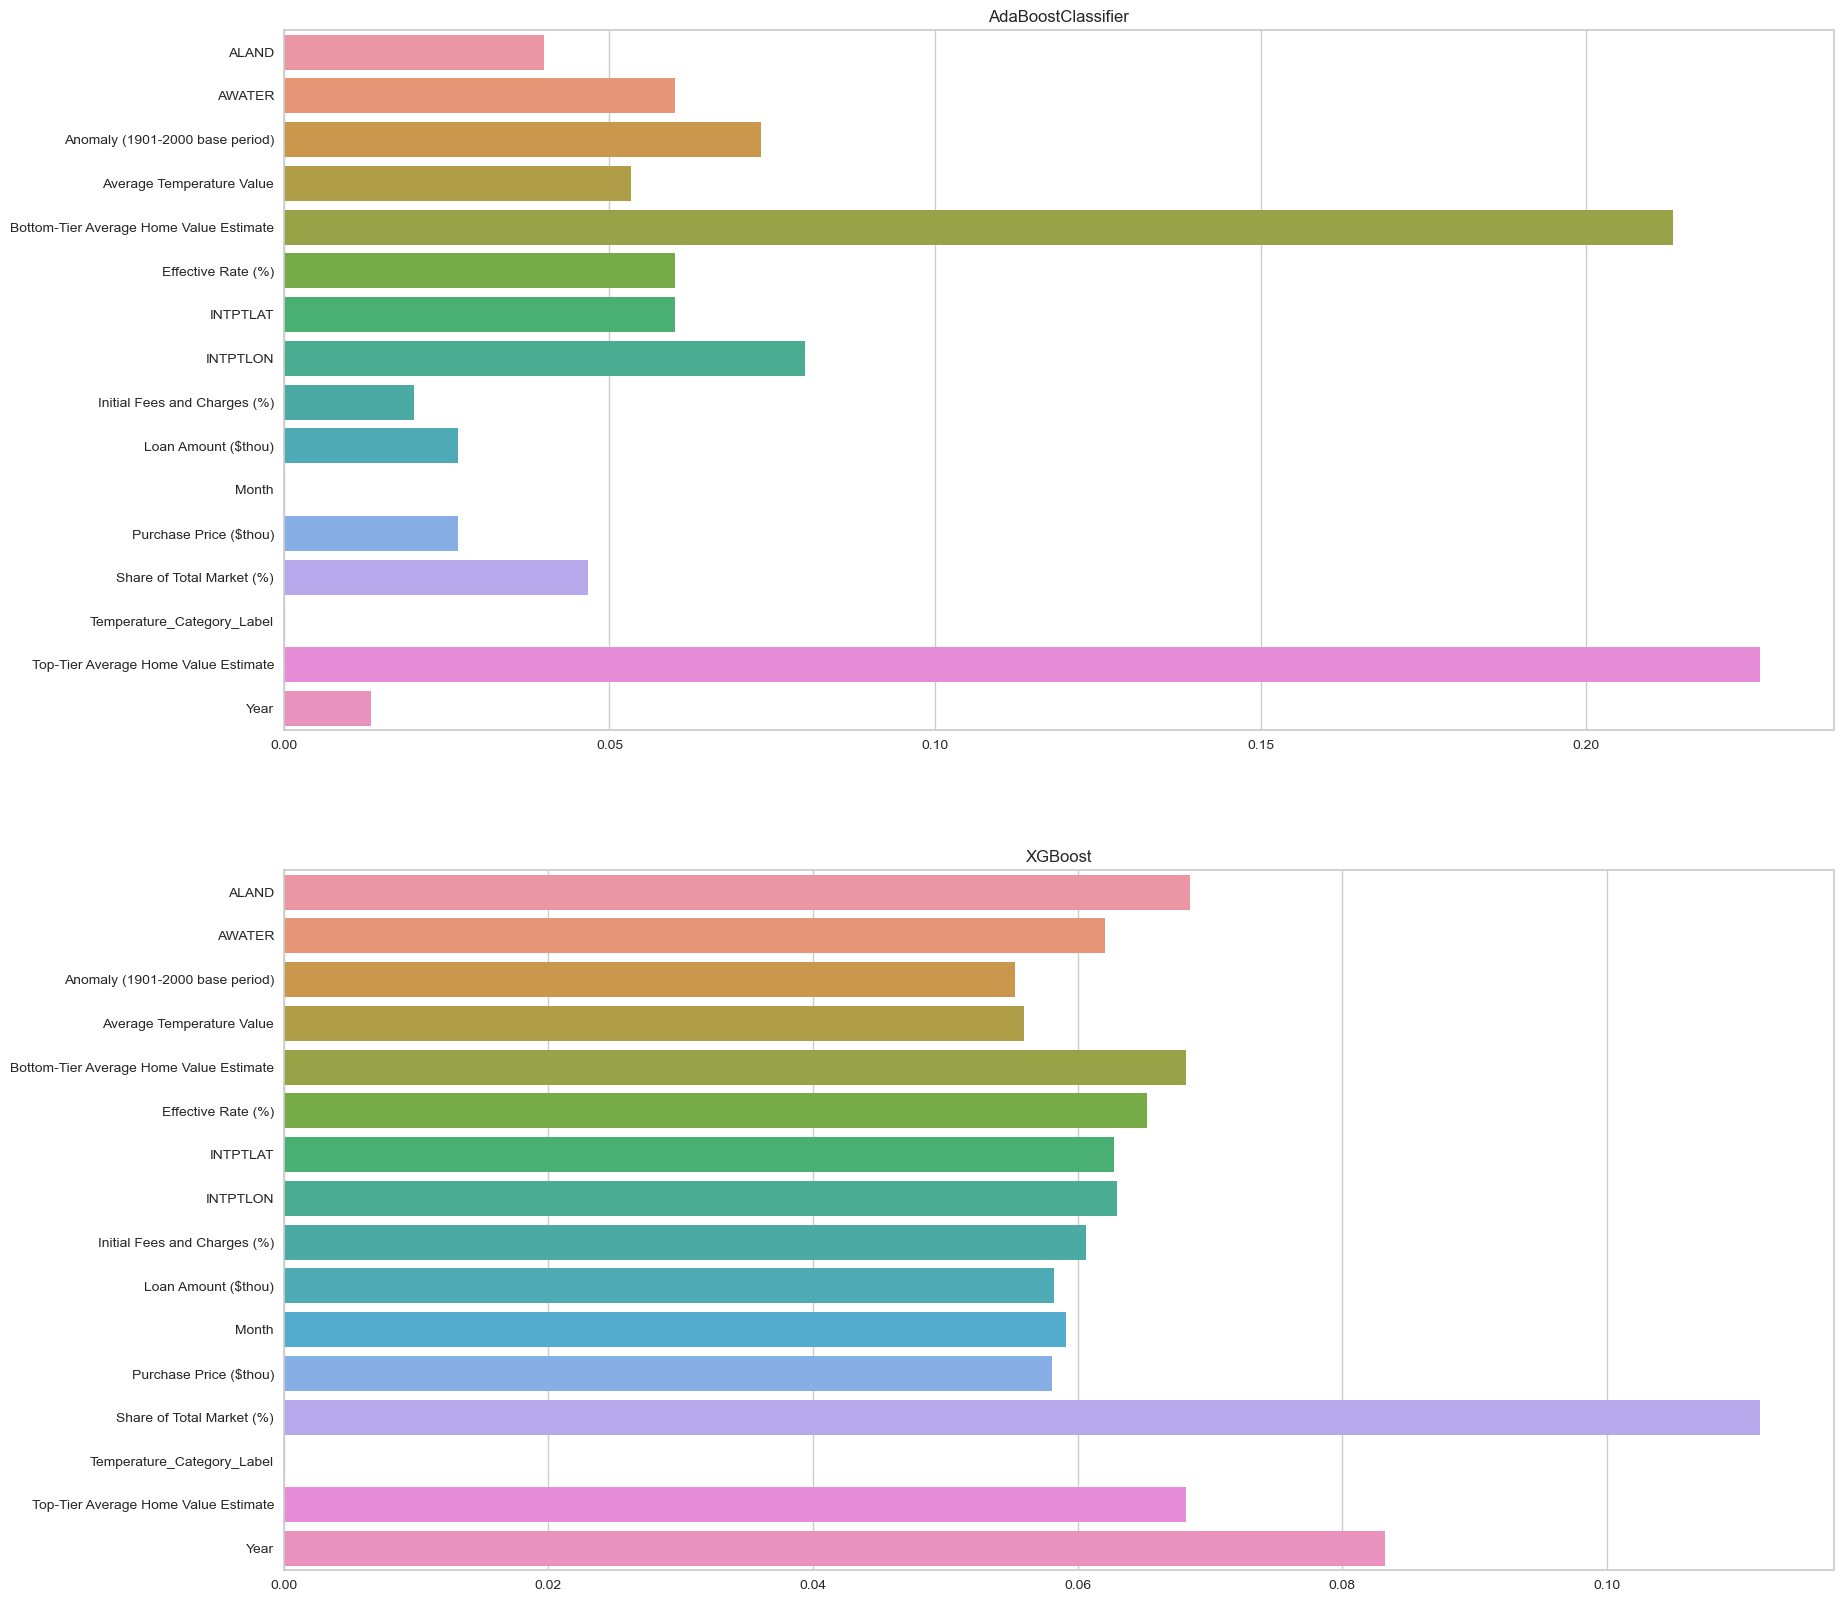

In [76]:
# your code here

fig, axes = plt.subplots(2, 1, figsize=(20,20))

# Plot 1: Cold States ABC
sns.barplot(x=abc_best_cold.feature_importances_, y= X.columns ,  ax=axes[0])
axes[0].set_title('AdaBoostClassifier')
# Plot 2: Cold States XGBoost
sns.barplot(x=xgb_best_cold.feature_importances_, y= X.columns, ax=axes[1])
axes[1].set_title('XGBoost')

### *All States*

Text(0.5, 1.0, 'XGBoost')

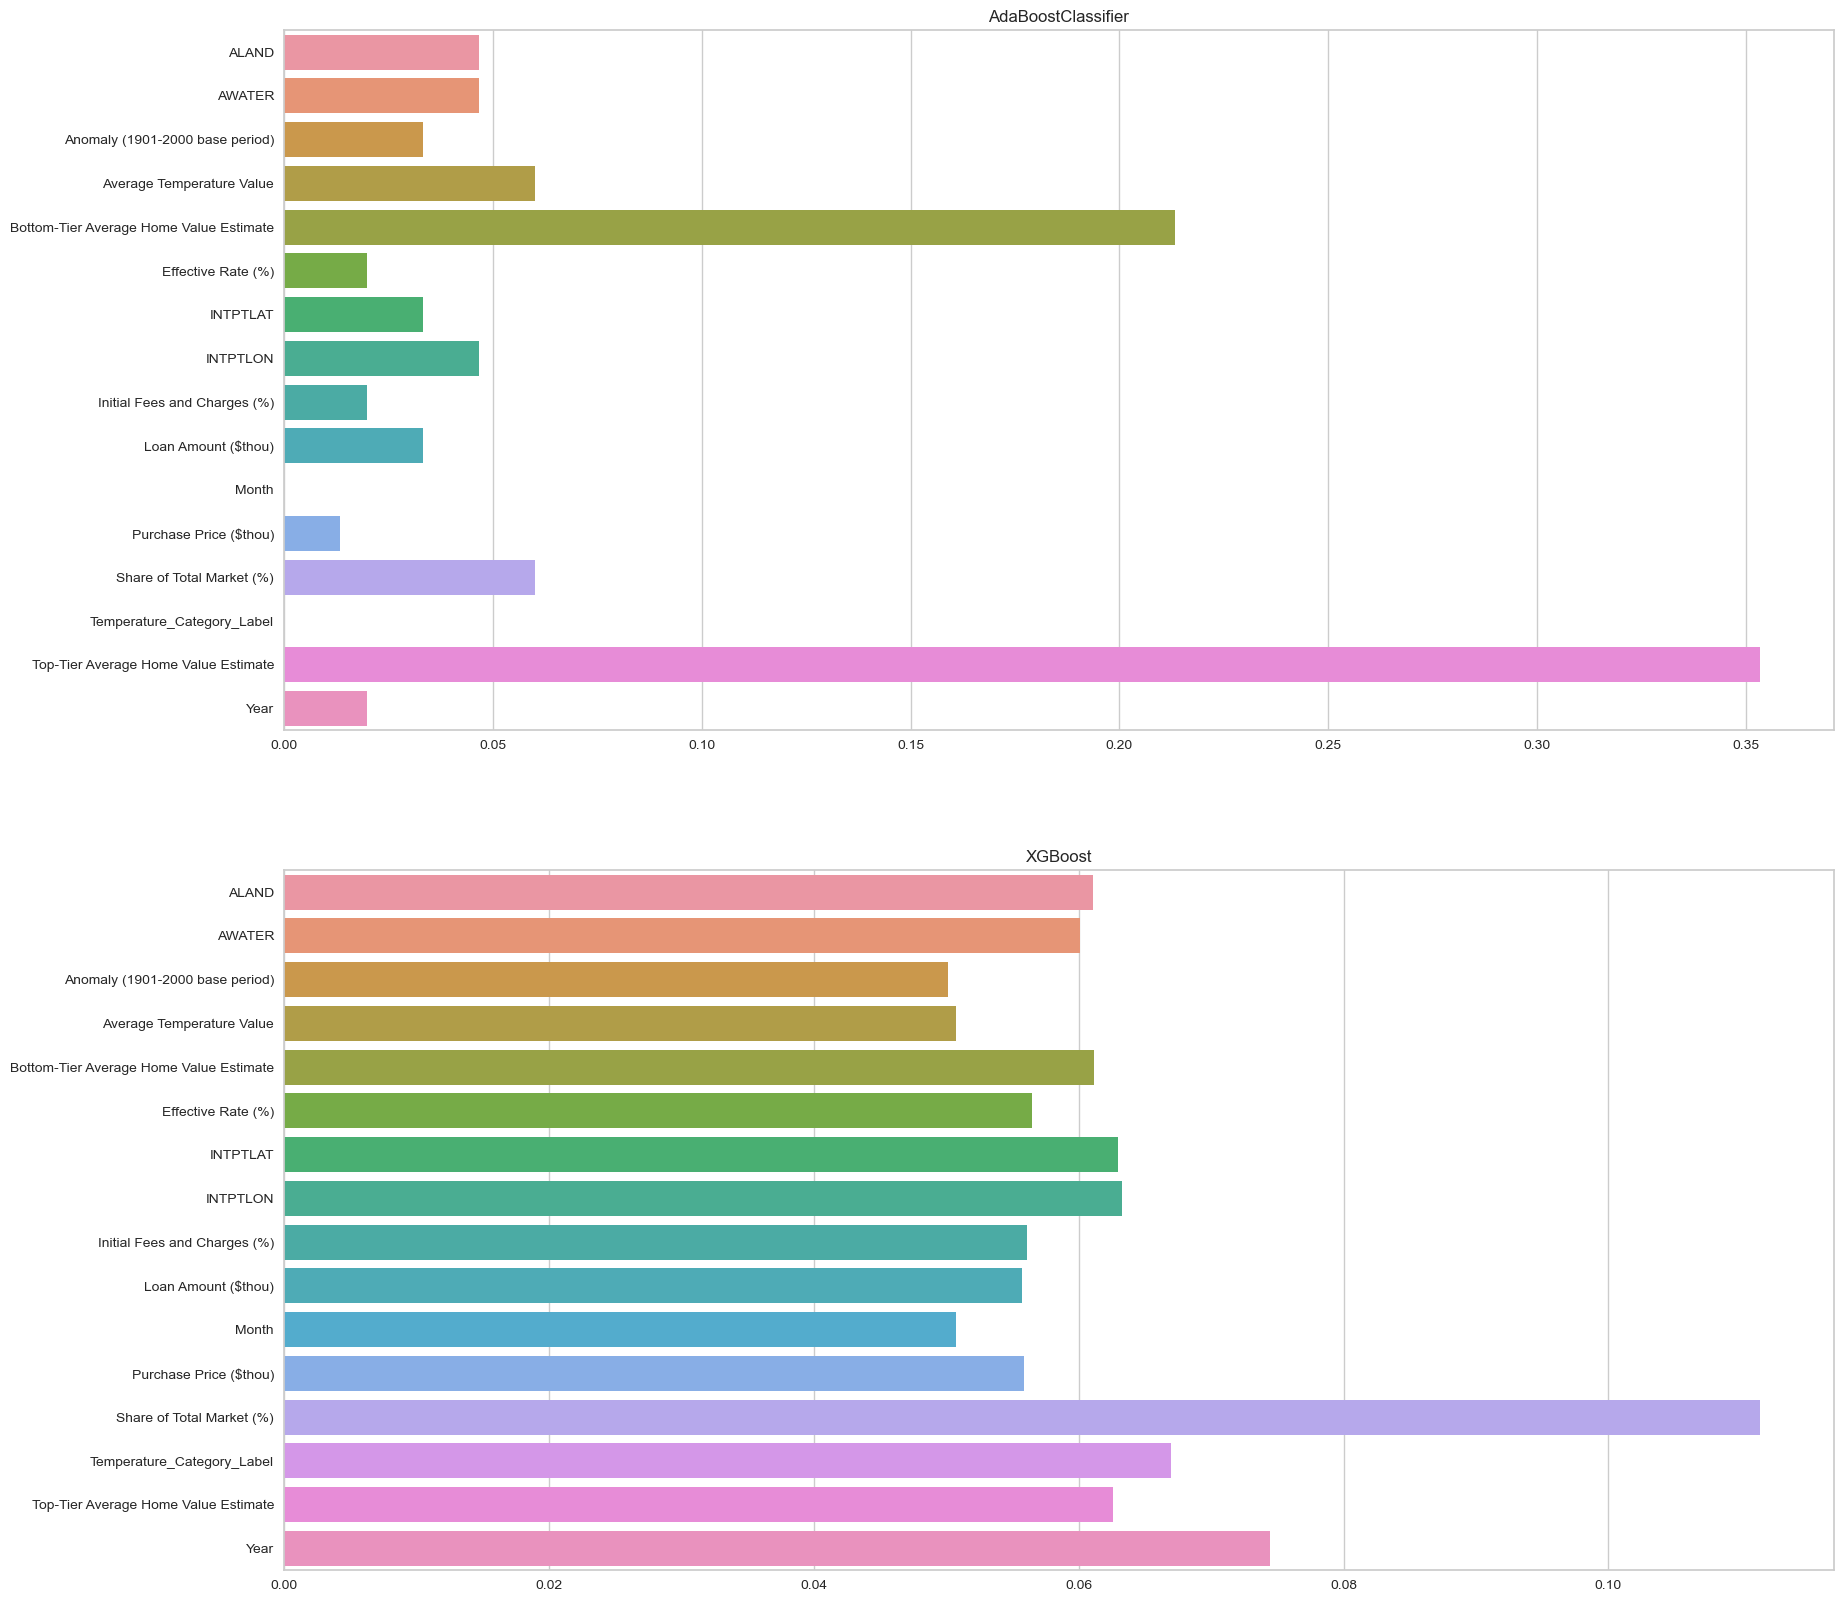

In [77]:
fig, axes = plt.subplots(2, 1, figsize=(20,20))

# Plot 1: Cold States ABC
sns.barplot(x=abc_best_all.feature_importances_, y= X.columns ,  ax=axes[0])
axes[0].set_title('AdaBoostClassifier')
# Plot 2: Cold States XGBoost
sns.barplot(x=xgb_best_all.feature_importances_, y= X.columns, ax=axes[1])
axes[1].set_title('XGBoost')

### Interpretation looking at Warm States and Cold States and All States
We had a very big dataset, so to create a classification model we wanted to  segment it into three regions: states with warmer climates, colder climates, and a combined dataset of all states. Since XGBoost and AdaModel performed the best with warm states, XGBoost and AdaModel showed the most promising performance in warmer states, I decided to apply these models to the subset of data from colder states and then to the dataset containing all states. We still see that XG Boost does the best in including all the features even though it doesn't do the best in recall. XgBoost was the top performer by incorporating all features comprehensively. The feature importance analysis revealed that the share of the total market (%) ranked highest, while variables like temperature category label, average temperature, and purchase price value significantly influenced whether a state/county was classified as an outlier.

___
### Feature Selection for All States 
We do see that temperature category lable does play into feature importances when we look at all the states. We want to do some feature importances for this and see how the model runs. We will be choosing these features 'Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)',
'Loan Amount ($thou)', 'Temperature_Category_Label', 'Share of Total Market (%)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate'

In [84]:
from sklearn.preprocessing import MinMaxScaler

#your code here
seed=11

#standardizing the data 
X = data[data.columns.difference(['Is_Outlier'])]
y = data['Is_Outlier']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

columns_to_scale = ['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)',
'Loan Amount ($thou)', 'Temperature_Category_Label', 'Share of Total Market (%)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.25, random_state=seed)

X_train_all_selected = X_train_all[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)',
'Loan Amount ($thou)', 'Temperature_Category_Label', 'Share of Total Market (%)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate']]
X_test_all_selected = X_test_all[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)',
'Loan Amount ($thou)', 'Temperature_Category_Label', 'Share of Total Market (%)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate']]

# Fit the scaler to the specified columns of the training data
scaler.fit(X_train_all_selected[columns_to_scale])

# Transforming the train and test data based on the fitted scaler
X_train_all_states_selected = X_train_all_selected.copy()
X_train_all_states_selected[columns_to_scale] = scaler.transform(X_train_all_selected[columns_to_scale])

X_test_all_states_selected = X_test_all_selected.copy()
X_test_all_states_selected[columns_to_scale] = scaler.transform(X_test_all_selected[columns_to_scale])

print(y_test_all)

417200    0.0
391878    0.0
342082    0.0
69162     0.0
463507    1.0
         ... 
115776    0.0
7306      1.0
371931    0.0
23020     0.0
506470    0.0
Name: Is_Outlier, Length: 126088, dtype: float64


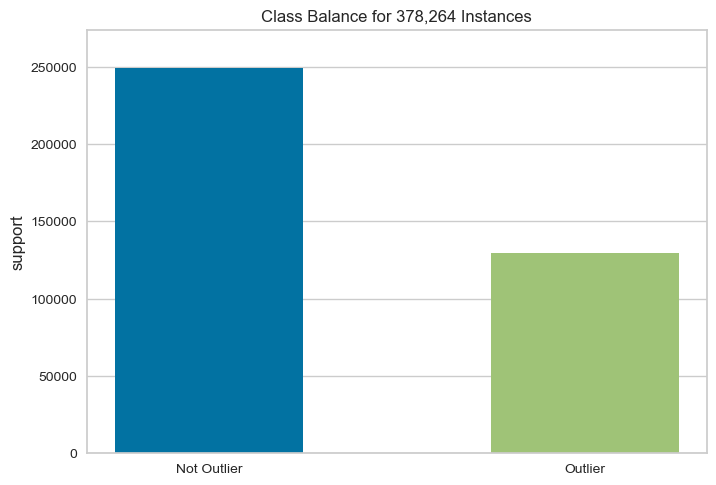

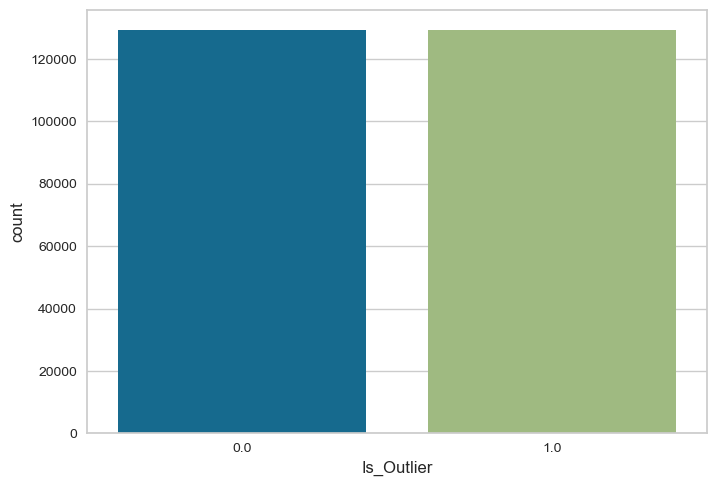

In [85]:
#We want to undersample
# your code here
labels = ["Not Outlier", "Outlier"]
visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train_all)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_all_resampled_selected, y_train_all_resampled_selected = rus.fit_resample(X_train_all_states_selected, y_train_all)

# Visualize class balance after undersampling
sns.countplot(x=y_train_all_resampled_selected, tick_label=labels)
plt.show()

              precision    recall  f1-score   support

 Not Outlier       0.76      0.49      0.59     82844
     Outlier       0.42      0.71      0.53     43244

    accuracy                           0.56    126088
   macro avg       0.59      0.60      0.56    126088
weighted avg       0.64      0.56      0.57    126088



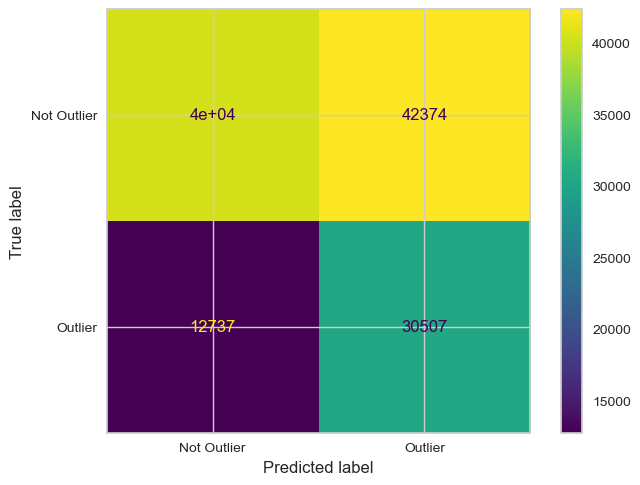

In [86]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# your code here
xgb_best_selected = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_best_selected.fit(X_train_all_resampled_selected, y_train_all_resampled_selected)

#Evaluate the model, Predictions
y_pred_train_xgb_best_all = xgb_best_selected.predict(X_train_all_resampled_selected)
y_pred_test_xgb_best_all_selected = xgb_best_selected.predict(X_test_all_states)

# Confusion matrix
cm = confusion_matrix(y_test_all, y_pred_test_xgb_best_all_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_all, y_pred_test_xgb_best_all_selected, target_names=labels))

As seen above, our model performs slightly worse with feature selection so it is best to use all of our features this can be attributed to discarding potentially relevant information from the dataset.The features we left out may contain valuable patterns that contribute to the model's predictive powers. Also the features often interact with each other in complex ways which could be the case with our data so by removing features, we may disrupt these intricate relationships. In general it might just be underfitting the data so we will go with out previous models, we just wanted to see what it would look like. 